# Sterile Neutrino Production

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


import numpy as np
#from odeintw import odeintw
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import quad, ode, solve_ivp, odeint
from scipy.optimize import root
from scipy.optimize import fsolve

# from scipy.special import zeta, kn
import scipy.special as sp
from scipy.interpolate import interp1d, RectBivariateSpline
from math import sqrt, log, exp, log10, pi, atan
from mpmath import expint
from mpmath import findroot
from scipy.special import lambertw

plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=r"\usepackage{amsmath, amssymb}"
plt.rc('font', **{'family' : 'serif', 'size' : 15})


In [2]:
#-------------------------------------#
#    g*(T) and g*S(T) interpolation   #
#-------------------------------------#

Dataset 6
Ttab = gTab.iloc[:,0] # temperature
gtab = gTab.iloc[:,1] # value
tck  = interpolate.splrep(Ttab, gtab, s=0)

def gstarT(T): 
    return interpolate.splev(T, tck, der=0)

gSTab = pd.read_table(r"/home/yongxu/Documents/research/Research_Code/py_projects/BH_superradiance/Superradiance_code/Data/gstarS.dat", names=['T','gstarS'])

TStab = gSTab.iloc[:,0]
gstab = gSTab.iloc[:,1]
tckS  = interpolate.splrep(TStab, gstab, s=0)

def gstarST(T): 
    return interpolate.splev(T, tckS, der = 0)
# -----------------------------
# Physical constants (GeV units)
# -----------------------------
G_F = 1.1663787e-5        # Fermi constant, GeV^-2
Mpl = 1.2209e19           # Planck mass, GeV
Mp = Mpl / np.sqrt(8*np.pi)
pi = np.pi
zeta3 = 1.2020569031595942
# kept legacy gstar constant only as a fallback/initial guess
gstar_const = 10.75

# -----------------------------
# Utility functions (with fix for T_from_rho_rad)
# -----------------------------
def rho_rad_from_T(T):
    """Radiation energy density from temperature using interpolated g*(T).
       T in GeV, returns rho in GeV^4.
    """
    T_arr = np.asarray(T)
    g = gstarT(T_arr)
    return (pi**2 / 30.0) * g * T_arr**4

def T_from_rho_rad(rho, tol=1e-10, maxiter=60):
    """
    Solve for T from rho using iterative scheme with gstarT(T).
    rho: scalar or array (GeV^4)
    Returns T in GeV (same shape)
    """
    rho_arr = np.asarray(rho)
    # protect extremely small/negative rho
    rho_safe = np.maximum(rho_arr, 1e-300)

    # initial guess: assume constant gstar_const
    T0 = (rho_safe * 30.0 / (pi**2) / gstar_const)**0.25

    T = T0
    # iterative fixed-point: T_new = (rho*30/pi^2 / gstarT(T_old))^(1/4)
    for _ in range(maxiter):
        g = gstarT(T)
        # protect g
        g = np.maximum(g, 1e-8)
        T_new = (rho_safe * 30.0 / (pi**2) / g)**0.25
        # relative change
        rel = np.max(np.abs((T_new - T) / np.maximum(T, 1e-20)))
        T = T_new
        if rel < tol:
            break
    else:
        # if not converged, still return last iterate but warn (commented out)
        # print("Warning: T_from_rho_rad did not converge fully; rel = {:.3e}".format(rel))
        pass

    # if input scalar return scalar
    if np.isscalar(rho):
        return float(T)
    return T

def H_from_rho(rho):
    return np.sqrt(8 * pi / 3.0 * rho / Mpl**2)

def f_eq(x):
    """Stable Fermi-Dirac distribution for array x = p/T."""
    x = np.array(x)
    out = np.zeros_like(x, dtype=float)
    mask = x < 700.0
    out[mask] = 1.0 / (np.exp(x[mask]) + 1.0)
    return out


# dof is missing?
def n_eq_T(T):
    """Equilibrium number density prefactor (per neutrino degree of freedom)."""
    return 3.0/4.0 * zeta3 / (pi**2) * T**3

# -----------------------------
# comoving momentum grid q = a*p
# -----------------------------
q_min = 1e-3
q_max = 1e6
N_q = 100  
q_grid = np.logspace(np.log10(q_min), np.log10(q_max), N_q)

# -----------------------------
# Gamma_alpha(p,T)
# -----------------------------
# def Gamma_alpha_of_pT(p, T, flavor='e'):
#     C_factors = {'e': 1.27, 'mu': 0.92, 'tau': 0.92}
#     C = C_factors.get(flavor, 0.0)
#     p_safe = np.maximum(p, 1e-300)
#     T_safe = np.maximum(T, 1e-300)
#     return C * (G_F**2) * p_safe * T_safe**4

# from arXiv:1909.13328

def Gamma_alpha_of_pT(p, T, flavor='e'):
    C_factors = {'e': 1.13, 'mu': 0.79, 'tau': 0.79}
    C = C_factors.get(flavor, 0.0)
    p_safe = np.maximum(p, 1e-300)
    T_safe = np.maximum(T, 1e-300)
    return C * (G_F**2) * p_safe * T_safe**4

# -----------------------------
# Thermal potential V_th(p,T)
# -----------------------------
def B_of_T(T, flavor):
    """
    Piecewise B(T) (in eV) based on the rules you provided.
    T in GeV.
    """
    T_MeV = T * 1e3
    if T_MeV <= 20.0:
        if flavor == 'e':
            return 10.79
        elif flavor == 'mu':
            return 3.02
        elif flavor == 'tau':
            return 3.02
    elif T_MeV <= 180.0:
        if flavor == 'e':
            return 10.79
        elif flavor == 'mu':
            return 10.79
        elif flavor == 'tau':
            return 3.02
    else:
        return 10.79

def V_thermal_of_pT(p, T, flavor='e'):
    p_safe = np.maximum(p, 1e-300)
    B_eV = B_of_T(T, flavor)
    B_GeV = B_eV * 1e-9
    return - B_GeV * (T**4) * p_safe

# -----------------------------
# Finite-density (asymmetry) potential V_D
# -----------------------------
def V_density_of_T(T, L_alpha=0.0, eta=0.0, flavor='e'):
    sign = 1.0 if flavor=='e' else -1.0
    pref = (2.0 * np.sqrt(2.0) * zeta3 / (pi**2)) * G_F * T**3
    return pref * (L_alpha + sign * eta / 4.0)

def V_effective_of_pT(p, T, L_alpha=0.0, eta=0.0, flavor='e'):
    return V_density_of_T(T, L_alpha=L_alpha, eta=eta, flavor=flavor) + V_thermal_of_pT(p, T, flavor=flavor)

# -----------------------------
# Oscillation production C_osc_for_flavor
# -----------------------------
def C_osc_for_flavor(fa, fs, ms, T, x_vals, sin2_2theta, flavor='e', L_alpha=0.0, eta=0.0):
    p = x_vals * T
    p_safe = np.maximum(p, 1e-300)
    Delta = ms**2 / (2.0 * p_safe)         # [GeV]
    Gamma_alpha = Gamma_alpha_of_pT(p_safe, T, flavor=flavor)  # [GeV]
    D = Gamma_alpha / 2.0
    Veff = V_effective_of_pT(p_safe, T, L_alpha=L_alpha, eta=eta, flavor=flavor)
    cos2theta = np.sqrt(np.maximum(1.0 - sin2_2theta, 0.0))
    denom = (Delta**2) * sin2_2theta + D**2 + (Delta * cos2theta - Veff)**2
    numer = (Gamma_alpha / 4.0) * (Delta**2) * sin2_2theta
    denom_safe = np.maximum(denom, 1e-300)
    # return (numer / denom_safe) * (fa - fs)
    return (numer / denom_safe) * (fa*(1-fs) - fs*(1-fa))
    # return (numer / denom_safe) * (fa*(1-fs))

def C_from_phi_decay(p, rho_phi, Gamma_phi, mphi, BR):
    """
    Approximates delta function as a narrow Gaussian in momentum q.
    q_grid: comoving momentum array
    a: scale factor
    rho_phi: inflaton energy density at this a
    Gamma_phi: total inflaton decay rate
    mphi: inflaton mass
    BR: branching ratio to sterile neutrino
    Returns df_s/dln a array.
    """
    n_phi = rho_phi / mphi
    p0 = mphi / 2.0

    sigma = p0 * 0.01  # 1% width to approximate delta function
    prefactor = BR * 8 * np.pi**2 * Gamma_phi * n_phi / mphi**2
    df_s = prefactor * (1.0 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-0.5 * ((p - p0)/sigma)**2)
    return df_s


# -----------------------------
# RHS building with four flavors
# -----------------------------
def make_rhs_lna_comoving_full(TR, ms, sin2_2theta, mphi, BR,
                               L_alpha_e=0.0, L_alpha_mu=0.0, L_alpha_tau=0.0,
                               eta=0.0, print_dlna=0.2,
                               flavor_for_Gamma='e'):
    TR_GeV = TR
    Gamma_phi = 2.45 * H_from_rho(rho_rad_from_T(TR_GeV))
    sin2_2th = sin2_2theta
    last_print = [-1e9]

    def rhs(ln_a, y):
        idx = 0
        rho_phi = y[idx]; idx += 1
        rho_rad = y[idx]; idx += 1

        f_e = y[idx: idx+N_q].copy(); idx += N_q
        f_mu = y[idx: idx+N_q].copy(); idx += N_q
        f_tau = y[idx: idx+N_q].copy(); idx += N_q
        f_s = y[idx: idx+N_q].copy(); idx += N_q

        rho_tot = np.maximum(rho_phi + rho_rad, 1e-300)
        H = H_from_rho(rho_tot)

        # ---- HERE use iterative T_from_rho_rad (fixed) ----
        T = T_from_rho_rad(np.maximum(rho_rad, 1e-300))
        a = np.exp(ln_a)

        # physical momentum p, and x = p/T
        p_grid = q_grid / a
        x_vals = p_grid / T

        f_eq_grid = f_eq(x_vals)

        coll_e = (Gamma_alpha_of_pT(p_grid, T, 'e') / H) * (f_eq_grid - f_e)
        coll_mu = (Gamma_alpha_of_pT(p_grid, T, 'mu') / H) * (f_eq_grid - f_mu)
        coll_tau = (Gamma_alpha_of_pT(p_grid, T, 'tau') / H) * (f_eq_grid - f_tau)

        C_e = C_osc_for_flavor(f_e, f_s, ms, T, x_vals, sin2_2th, flavor='e', L_alpha=L_alpha_e, eta=eta)
        # C_mu = C_osc_for_flavor(f_mu, f_s, ms, T, x_vals, sin2_2th, flavor='mu', L_alpha=L_alpha_mu, eta=eta)
        # C_tau = C_osc_for_flavor(f_tau, f_s, ms, T, x_vals, sin2_2th, flavor='tau', L_alpha=L_alpha_tau, eta=eta)
        C_phi = C_from_phi_decay(p_grid, rho_phi, Gamma_phi, mphi, BR)

        # prod_s = (C_e + C_mu + C_tau) / H

        prod_s = (C_e) / H +  C_phi/ H

        drho_phi_dlna = -3.0 * rho_phi - (Gamma_phi / H) * rho_phi
        drho_rad_dlna = -4.0 * rho_rad + (Gamma_phi / H) * rho_phi

        # df_e_dlna = coll_e - C_e 
        # df_mu_dlna = coll_mu -  C_mu 
        # df_tau_dlna = coll_tau - C_tau
        df_e_dlna = coll_e - C_e 
        df_mu_dlna = coll_mu
        df_tau_dlna = coll_tau 
        df_s_dlna = prod_s 

        # if print_dlna and (ln_a - last_print[0]) >= print_dlna:
        #     ratio = rho_phi / np.maximum(rho_rad, 1e-300)
        #     print(f"[ln a = {ln_a:.3f}] T = {T*1e3:.6f} MeV, rho_phi/rho_rad = {ratio:.3e}, max(Gamma_e/H) = {np.max(Gamma_alpha_of_pT(p_grid, T, 'e')/H):.3e}")
        #     last_print[0] = ln_a

        # if print_dlna and (ln_a - last_print[0]) >= print_dlna:
        #     ratio = rho_phi / np.maximum(rho_rad, 1e-300)
        #     print(f"[ln a = {ln_a:.3f}] T = {T*1e3:.6f} MeV, rho_phi/rho_rad = {ratio:.3e}")
        #     last_print[0] = ln_a
            
        out = np.empty_like(y)
        j = 0
        out[j] = drho_phi_dlna; j += 1
        out[j] = drho_rad_dlna; j += 1
        out[j:j+N_q] = df_e_dlna; j += N_q
        out[j:j+N_q] = df_mu_dlna; j += N_q
        out[j:j+N_q] = df_tau_dlna; j += N_q
        out[j:j+N_q] = df_s_dlna
        return out

    return rhs

# -----------------------------
# Runner
# -----------------------------
def run_ln_comoving_full(TR_MeV=4.0, Hubble_end = 1e-20, ms_keV=1.0, sin2_2theta=1e-2, mphi=1e2, BR=0.0,
                         ln_a_span=(0.0, 15.0),
                         L_alpha_e=0.0, L_alpha_mu=0.0, L_alpha_tau=0.0,
                         eta=0.0, print_dlna=0.5):
    TR = TR_MeV * 1e-3
    ms = ms_keV * 1e-6

    # initial conditions (tunable)
    rho_rad_init = 1e-20
    HI = Hubble_end 
    rho_phi_init = 3.0 * HI**2 * Mp**2
    f0 = np.zeros(N_q)
    y0 = np.concatenate([[rho_phi_init, rho_rad_init], f0, f0, f0, f0])

    rhs = make_rhs_lna_comoving_full(TR, ms, sin2_2theta, mphi, BR,
                                     L_alpha_e=L_alpha_e, L_alpha_mu=L_alpha_mu, L_alpha_tau=L_alpha_tau,
                                     eta=eta, print_dlna=print_dlna)

    # sol = solve_ivp(rhs, ln_a_span, y0, method='Radau', atol=1e-9, rtol=1e-9, max_step=0.05)
    sol = solve_ivp(rhs, ln_a_span, y0, method='Radau', atol=1e-10, rtol=1e-10, max_step=0.08)



    ln_a = sol.t
    a_array = np.exp(ln_a)
    n_t = len(ln_a)

    idx = 2
    f_e = sol.y[idx: idx+N_q, :]; idx += N_q
    f_mu = sol.y[idx: idx+N_q, :]; idx += N_q
    f_tau = sol.y[idx: idx+N_q, :]; idx += N_q
    f_s = sol.y[idx: idx+N_q, :]; idx += N_q
    
    # dof is missing?
    prefactor = 1.0 / (2.0 * np.pi**2)
    n_e = np.empty(n_t)
    n_mu = np.empty(n_t)
    n_tau = np.empty(n_t)
    n_s = np.empty(n_t)
    n_eq = np.empty(n_t)
    # T_array =  T_from_rho_rad(sol.y[1])
    T_sol = T_from_rho_rad(sol.y[1])
    for i in range(n_t):
        a = a_array[i]
        T = T_sol[i]      # <-- 必须知道 T(a)
        x_grid = q_grid / (a * T)
        n_e[i] = prefactor * np.trapezoid(f_e[:, i] * q_grid**2, q_grid) / a**3
        n_mu[i] = prefactor * np.trapezoid(f_mu[:, i] * q_grid**2, q_grid) / a**3
        n_tau[i] = prefactor * np.trapezoid(f_tau[:, i] * q_grid**2, q_grid) / a**3
        n_s[i] = prefactor * np.trapezoid(f_s[:, i] * q_grid**2, q_grid) / a**3
        n_eq[i]  = prefactor * np.trapezoid(f_eq(x_grid) * q_grid**2, q_grid) / a**3

  

    neq = n_eq_T(T_sol)

    s_entropy = (2.0 * np.pi**2 / 45.0) * gstarST(T_sol) * (T_sol**3)

    Y_s = n_s / s_entropy

    return {
        'ln_a': ln_a,
        'a': a_array,
        'T': T_sol,
        'n_e': n_e,
        'n_mu': n_mu,
        'n_tau': n_tau,
        'n_s': n_s,
        'n_e_over_neq': n_e / neq,
        'n_mu_over_neq': n_mu / neq,
        'n_tau_over_neq': n_tau / neq,
        'n_s_over_neq': n_s / neq,
        'f_e': f_e,
        'f_mu': f_mu,
        'f_tau': f_tau,
        'f_s': f_s,
        'q_grid': q_grid,
        'sol': sol,
        'Y_s': Y_s, 
        'ms_keV': ms_keV
    }

# import numpy as np
# import matplotlib.pyplot as plt

# -----------------------------
# Plot helpers (improved)
# -----------------------------

def plot_n_over_n_eq(result, Tmax_MeV=None, filename=None):
    T = result['T']
    re = result['n_e_over_neq']
    rmu = result['n_mu_over_neq']
    rtau = result['n_tau_over_neq']
    rs = result['n_s_over_neq']

    if Tmax_MeV is not None:
        mask = (T * 1e3) <= Tmax_MeV
        Tp = T[mask] * 1e3
        rep = re[mask]; rmup = rmu[mask]; rtp = rtau[mask]; rsp = rs[mask]
    else:
        Tp = T * 1e3
        rep = re; rmup = rmu; rtp = rtau; rsp = rs

    plt.figure(figsize=(7,5))
    plt.plot(Tp, rep, label=r"$\nu_e$", linewidth=2,  color='b')
    plt.plot(Tp, rmup, label=r"$\nu_\mu$", linewidth=2, color='g')
    plt.plot(Tp, rtp, label=r"$\nu_\tau$", linewidth=2, color='k', linestyle='--')
    plt.plot(Tp, rsp, label=r"$\nu_s$", linewidth=2, color='r')
  
    # plt.axhline(y=1, color='k', linestyle='--', linewidth=4)
    # plt.xscale("log")
    # plt.yscale("log")
    # plt.gca().invert_xaxis()  # 温度从高到低
    plt.xlabel(r'$T~[\text{MeV}]$')
    plt.ylabel(r'$n / n_{\rm eq}$')
    # plt.grid(alpha=0.4, which="both")
    plt.legend()
    plt.tight_layout()
        
    plt.savefig(filename, bbox_inches="tight")
    plt.show()    
    print(f"Saved file: {filename}")


def plot_energy_densities(result, filename=None):
    a = result['a']
    rho_phi = np.maximum(result['sol'].y[0], 1e-300)
    rho_rad = np.maximum(result['sol'].y[1], 1e-300)

    plt.figure(figsize=(7,5))
    plt.plot(a, rho_phi, label=r'$\rho_\phi$', color='b', linewidth=3)
    plt.plot(a, rho_rad, label=r'$\rho_R$', color='r', linewidth=3)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-18, 1e10)

    plt.xlabel(r'$a$')
    plt.ylabel(r'$\rho~[\text{GeV}^4] $')
    # plt.grid(alpha=0.4)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(filename, bbox_inches="tight")

    plt.show()
    print(f"Saved file: {filename}")


def T_at_rho_phi_eq_rho_R_interp(result, filename=None):
    rho_phi = result['sol'].y[0]
    rho_rad = result['sol'].y[1]
    ln_a = result['ln_a']
    T_sol = result['T']

    diff = rho_phi - rho_rad
    sign_change_idx = np.where(np.diff(np.sign(diff)))[0]

    if len(sign_change_idx) == 0:
        print("No crossing found!")
        return None, None

    i = sign_change_idx[0]

    ln_a_eq = ln_a[i] + (ln_a[i+1] - ln_a[i]) * (-diff[i]) / (diff[i+1] - diff[i])
    T_eq = T_sol[i] + (T_sol[i+1] - T_sol[i]) * (ln_a_eq - ln_a[i]) / (ln_a[i+1] - ln_a[i])
    a_eq = np.exp(ln_a_eq)

    print(f"rho_phi = rho_rad at a = {a_eq:.3e}, Temperature T = {T_eq*1e3:.3f} MeV")
    return T_eq, a_eq
   
    plt.savefig(filename, bbox_inches="tight")
    plt.show()
    print(f"Saved file: {filename}")


def plot_temperature_evolution(result, filename=None):
    ln_a = result['ln_a']
    a = np.exp(ln_a)
    T = np.maximum(result['T'], 1e-10)

    plt.figure(figsize=(7,5))
    plt.plot(a, T*1e3, label=r'$T~[\text{MeV}]$', color='r', linewidth=3)

    Teq, aeq = T_at_rho_phi_eq_rho_R_interp(result)
    if Teq is not None and aeq is not None:
        # plt.axhline(y=Teq*1e3, color='r', linestyle='--', label=f"T_rh = {Teq*1e3:.2f} MeV")
        # plt.axvline(x=aeq, color='g', linestyle='--', label=f"a_rh = {aeq:.2e}")
        plt.axhline(y=Teq*1e3, color='gray', linestyle='--')
        plt.axvline(x=aeq, color='gray', linestyle='--')
        

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r'$a$')
    plt.ylabel(r'$T~[\text{MeV}]$')
    # plt.grid(alpha=0.4, which="both")
    plt.legend()
    plt.tight_layout()
 
    plt.savefig(filename, bbox_inches="tight")
    plt.show()

    print(f"Saved file: {filename}")



def plot_momentum_spectra_x(result, flavors=('e','mu','tau','s'), filename=None):
    fmap = {'e': result['f_e'], 'mu': result['f_mu'], 'tau': result['f_tau'], 's': result['f_s']}
    ln_a_final = result['ln_a'][-1]
    a_final = np.exp(ln_a_final)
    # T_final = np.maximum(result['T'][-1], 1e-10)
    T_final = result['T'][-1]
    x = q_grid / (a_final * T_final)

    plt.figure(figsize=(7,5))
    # for lab in flavors:
    #     f = fmap[lab][:, -1]
    #     plt.plot(x, (x**3) * f, label=lab)
    plt.plot(x, x**3 * f_eq(x), color= 'gray', label=r'$f_{eq}$')

    plt.plot(x, (x**3) * fmap['e'][:, -1], color= 'b', label=r'$\nu_e$')
    plt.plot(x, (x**3) * fmap['mu'][:, -1], color= 'g', label=r'$\nu_\mu$')
    plt.plot(x, (x**3) * fmap['tau'][:, -1], color= 'k', linestyle='--',  label=r'$\nu_\tau$')
    plt.plot(x, (x**3) * fmap['s'][:, -1], color= 'r',  label=r'$\nu_s$')

    # plt.plot(x,  f_eq(x), color= 'gray', label=r'$f_{eq}$')

    # plt.plot(x, fmap['e'][:, -1], color= 'b', label=r'$\nu_e$')
    # plt.plot(x, fmap['mu'][:, -1], color= 'g', label=r'$\nu_\mu$')
    # plt.plot(x, fmap['tau'][:, -1], color= 'k', linestyle='--',  label=r'$\nu_\tau$')
    # plt.plot(x, fmap['s'][:, -1], color= 'r',  label=r'$\nu_s$')


    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-3, 1e2)

    plt.ylim(1e-20, 1e1)

    plt.xlabel(r'$x = p/T$')
    plt.ylabel(r'$x^3 f(x)$')
    # plt.grid(alpha=0.4, which="both")
    plt.legend()
    plt.tight_layout()
    plt.title(f"T = {T_final*1e3:.3f} MeV")
    plt.savefig(filename, bbox_inches="tight")

    plt.show()
    print(f"Saved file: {filename}")

def plot_Ys(result, filename=None):
    a = result['a']
    Y_s = result.get('Y_s')
    if Y_s is None: 
        print("No Y_s in result; please use updated run_ln_comoving_full(...)")
        return
    ms = result.get("ms_keV", None)
    if ms is None:
        raise ValueError("result has no key 'ms_keV'")

    Y_s_plot = np.maximum(Y_s, 1e-20)

    plt.figure(figsize=(7,5))
    plt.plot(a, Y_s_plot,  color='b', label=r'$Y_s = n_s/s$',  linewidth=2)

    plt.axhline(y=4.3*1e-10/(ms*1e-6), 
                color='gray', linestyle='--', label=r'$\Omega_s h^2 =0.12$', linewidth=5)

    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-20, 1e0)

    plt.xlabel(r'$a$')
    plt.ylabel(r'$Y_s$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    plt.show()

    print(f"Saved file: {filename}")


In [3]:
# if __name__ == "__main__":
#     res = run_ln_comoving_full(TR_MeV=4.0, ms_keV=1.0, sin2_2theta=1e-2, ln_a_span=(0,10), print_dlna=1.0)

# DM Production Scenarios
* $  T_\text{max} <  T_\text{peak}$  Freeze-in during reheating, production till $T_\text{max}$
    
* $T_\text{rh}  < T_\text{peak} < T_\text{max}$   Freeze-in during reheating, production till $T_\text{peak}$
    
* $ T_\text{peak}< T_\text{rh}$ Freeze-in after reheating, production till $T_\text{peak}$


# $  T_\text{max} <  T_{peak}$ 

In [21]:
res4= run_ln_comoving_full(TR_MeV=4.0, ms_keV=1.0, sin2_2theta=6*1e-4, ln_a_span=(0,10), print_dlna=1.0)

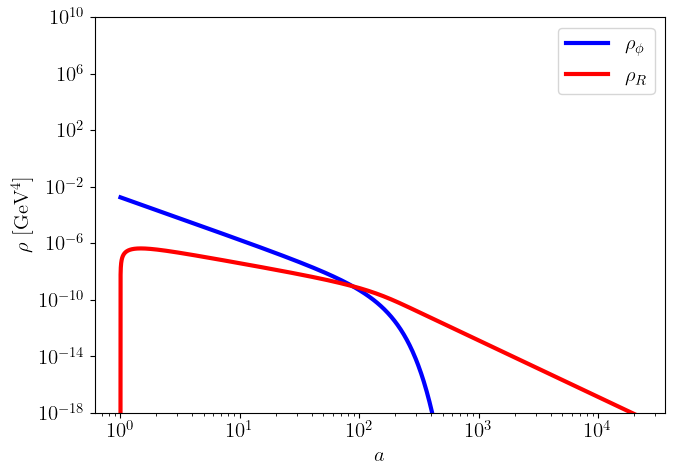

Saved file: rho_Trh_4MeV.pdf


In [22]:
plot_energy_densities(res4, filename="rho_Trh_4MeV.pdf")

rho_phi = rho_rad at a = 8.791e+01, Temperature T = 4.009 MeV


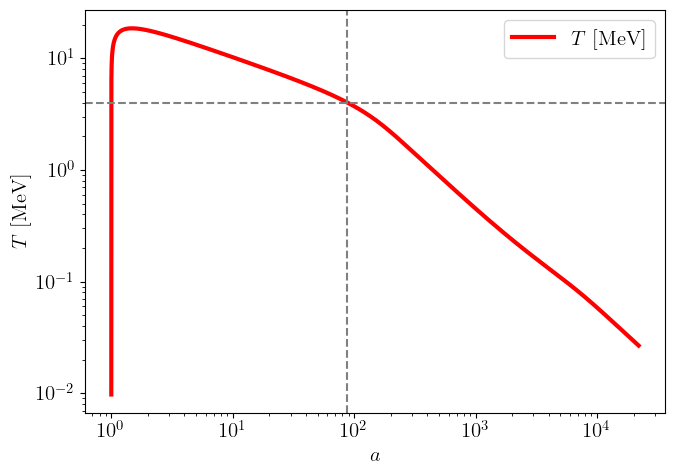

Saved file: T_Trh_4MeV.pdf


In [23]:
plot_temperature_evolution(res4,filename="T_Trh_4MeV.pdf")

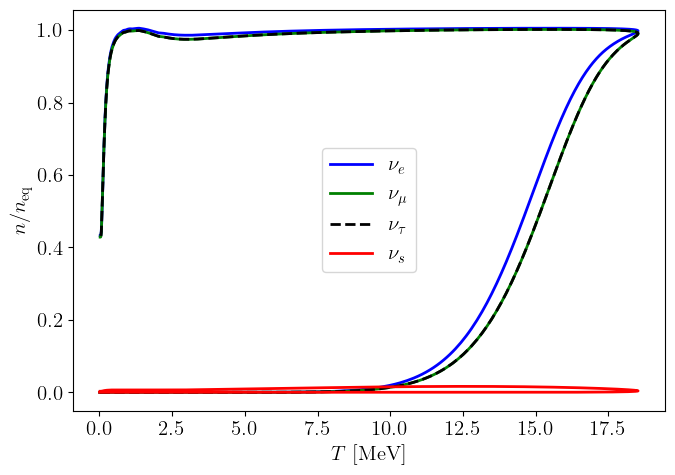

Saved file: n_Trh_4MeV.pdf


In [24]:
plot_n_over_n_eq(res4, Tmax_MeV=None,filename="n_Trh_4MeV.pdf")

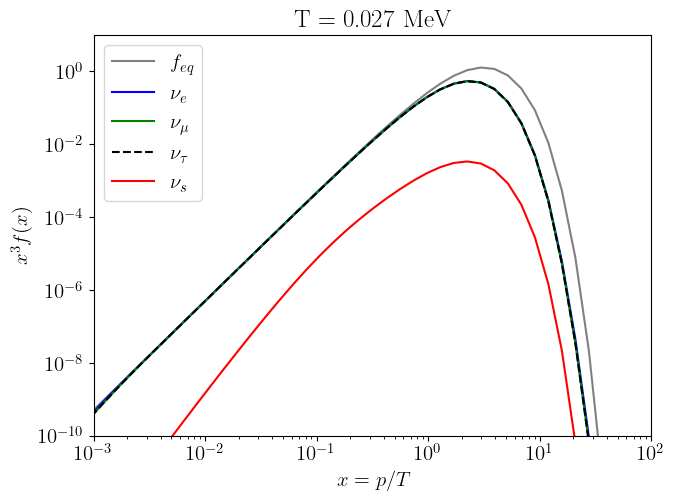

Saved file: f_Trh_4MeV.pdf


In [25]:
plot_momentum_spectra_x(res4, flavors=('e','mu','tau','s'), filename="f_Trh_4MeV.pdf")

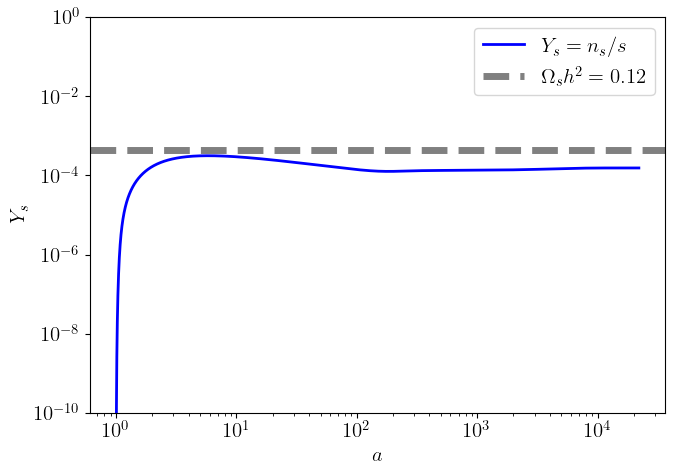

Saved file: Ys_Trh_4MeV.pdf


In [26]:
plot_Ys(res4, filename="Ys_Trh_4MeV.pdf")

# $T_{rh}  < T_{peak} < T_\text{max} $ 

In [42]:
# Large  HI # why independent from Tmax?
res4_2= run_ln_comoving_full(TR_MeV=4.0, Hubble_end = 1e-12, ms_keV=1.0, sin2_2theta=6*1e-4, ln_a_span=(0,24), print_dlna=1.0)

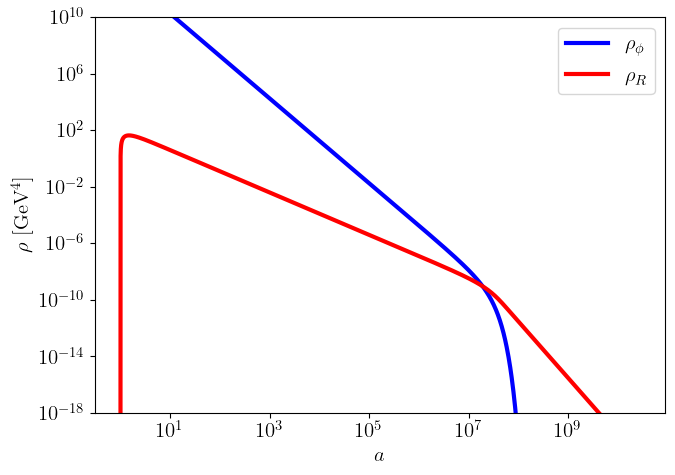

Saved file: rho_Trh_4MeV_Larger_HI.pdf


In [43]:
plot_energy_densities(res4_2,filename="rho_Trh_4MeV_Larger_HI.pdf")

rho_phi = rho_rad at a = 1.894e+07, Temperature T = 4.009 MeV


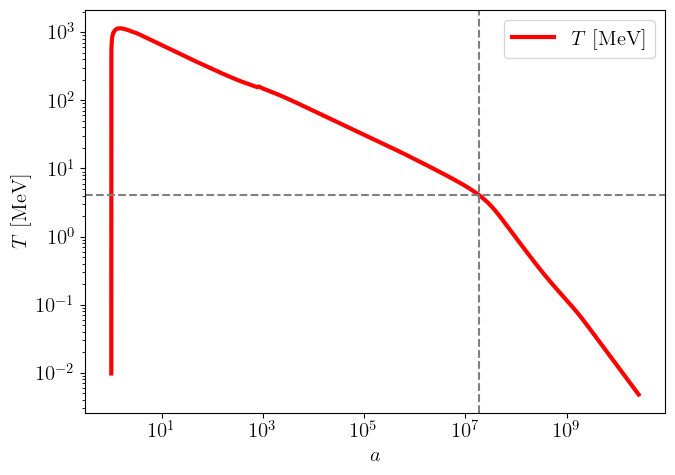

Saved file: T_Trh_4MeV_Larger_HI.pdf


In [44]:
plot_temperature_evolution(res4_2,filename="T_Trh_4MeV_Larger_HI.pdf")

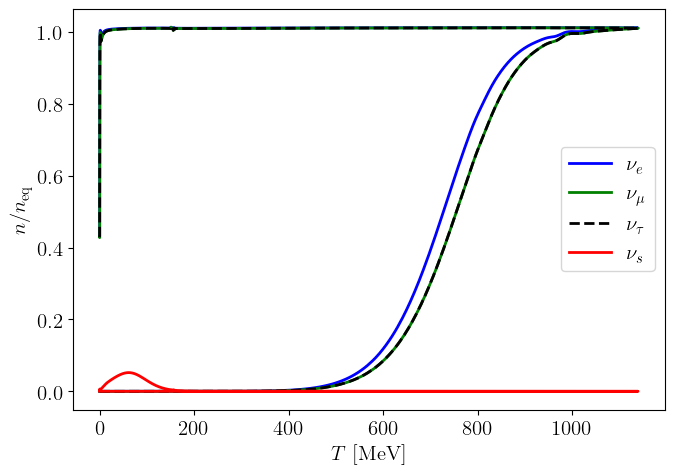

Saved file: n_Trh_4MeV_Larger_HI.pdf


In [45]:
plot_n_over_n_eq(res4_2, Tmax_MeV=None,filename="n_Trh_4MeV_Larger_HI.pdf")

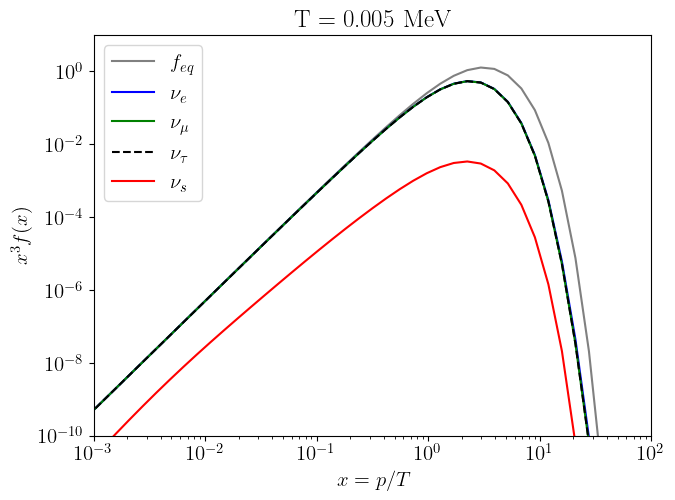

Saved file: f_Trh_4MeV_Larger_HI.pdf


In [46]:
plot_momentum_spectra_x(res4_2, flavors=('e','mu','tau','s'),filename="f_Trh_4MeV_Larger_HI.pdf")

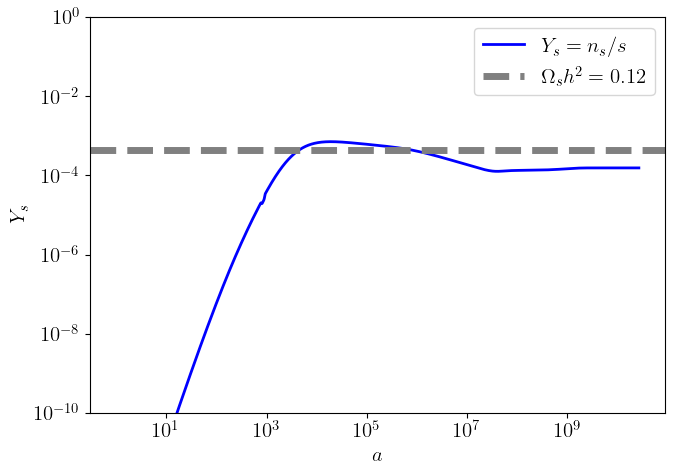

Saved file: Ys_Trh_4MeV_Larger_HI.pdf


In [47]:
plot_Ys(res4_2,filename="Ys_Trh_4MeV_Larger_HI.pdf")

# $ T_\text{peak}< T_\text{rh}$

In [48]:
res200= run_ln_comoving_full(TR_MeV=200, Hubble_end = 1e-10 ,ms_keV=1.0, sin2_2theta=7*1e-8, ln_a_span=(0,25), print_dlna=1.0)

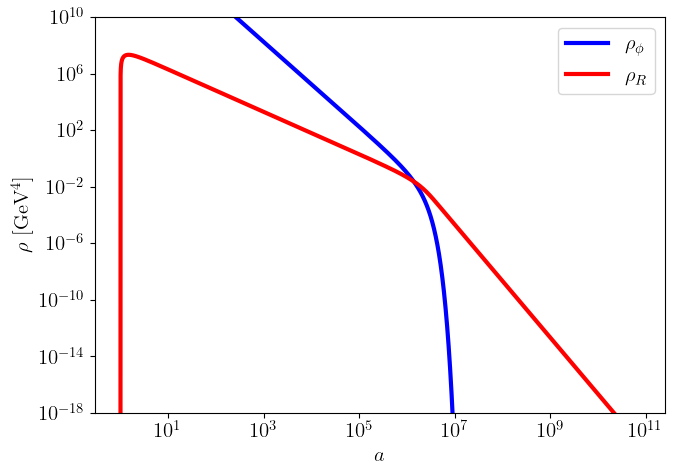

Saved file: rho_Trh_200MeV.pdf


In [49]:
plot_energy_densities(res200, filename="rho_Trh_200MeV.pdf")

rho_phi = rho_rad at a = 1.381e+06, Temperature T = 200.390 MeV


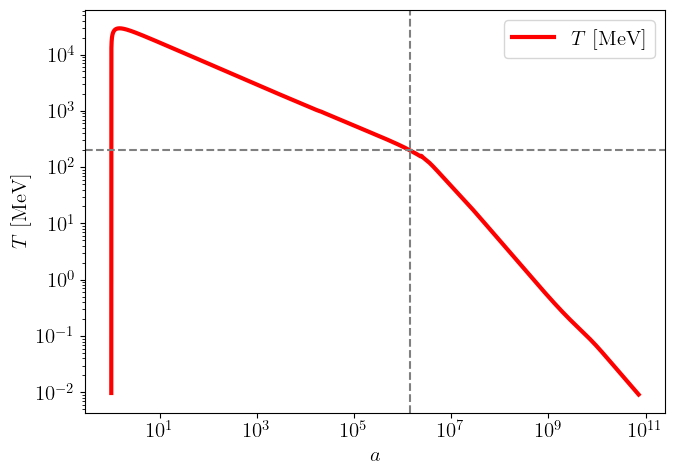

Saved file: T_Trh_200MeV.pdf


In [50]:
plot_temperature_evolution(res200,filename="T_Trh_200MeV.pdf")

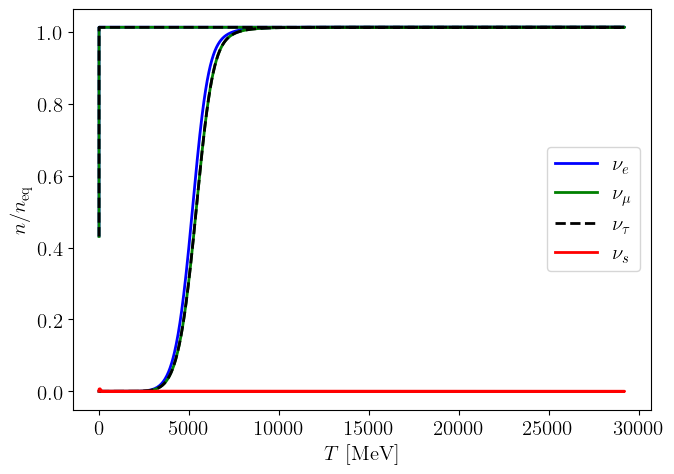

Saved file: n_Trh_200MeV.pdf


In [51]:
plot_n_over_n_eq(res200, Tmax_MeV=None,filename="n_Trh_200MeV.pdf")

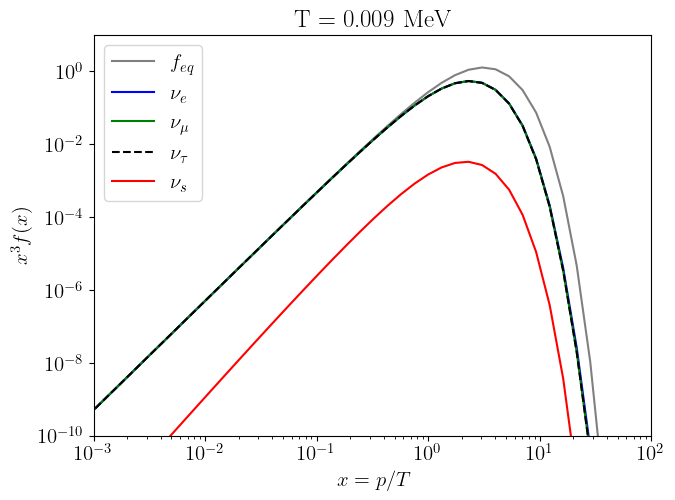

Saved file: f_Trh_200MeV.pdf


In [52]:
plot_momentum_spectra_x(res200, flavors=('e','mu','tau','s'), filename="f_Trh_200MeV.pdf")

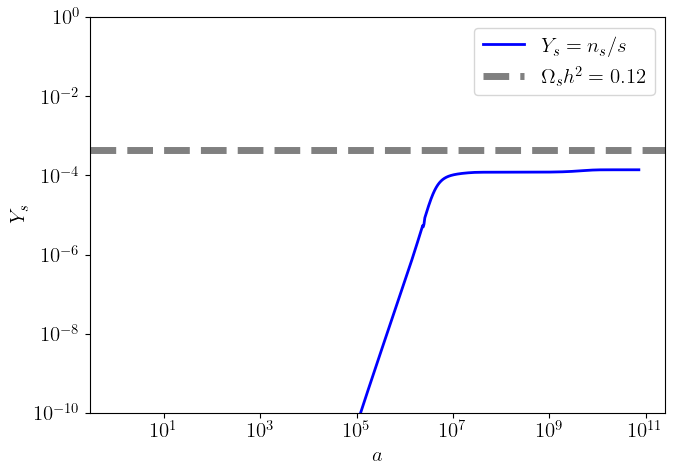

Saved file: Ys_Trh_200MeV.pdf


In [53]:
plot_Ys(res200,filename="Ys_Trh_200MeV.pdf")

In [126]:
# Ys_ms

# Compare with arXiv:1909.13328

In [58]:
res5= run_ln_comoving_full(TR_MeV=5.0, ms_keV=1.0, sin2_2theta=1*1e-3, ln_a_span=(0,10), print_dlna=1.0)

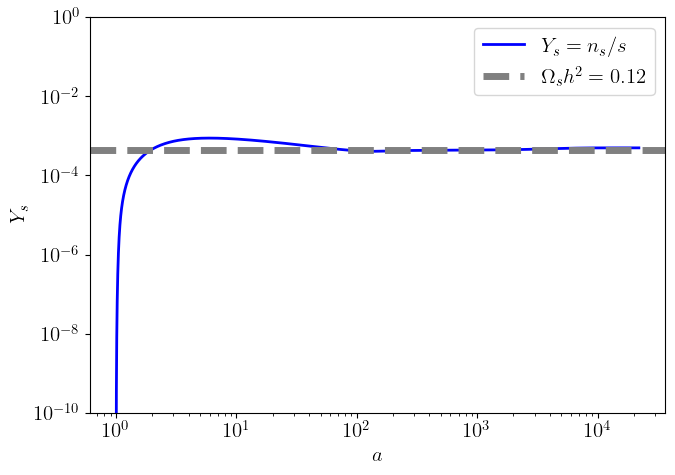

Saved file: Ys_Trh_5MeV.pdf


In [59]:
plot_Ys(res5,filename="Ys_Trh_5MeV.pdf")

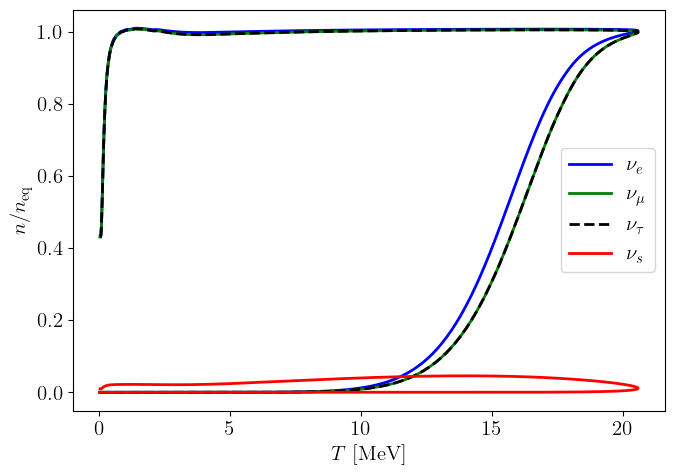

Saved file: n_Trh_5MeV.pdf


In [61]:
plot_n_over_n_eq(res5, Tmax_MeV=None,filename="n_Trh_5MeV.pdf")

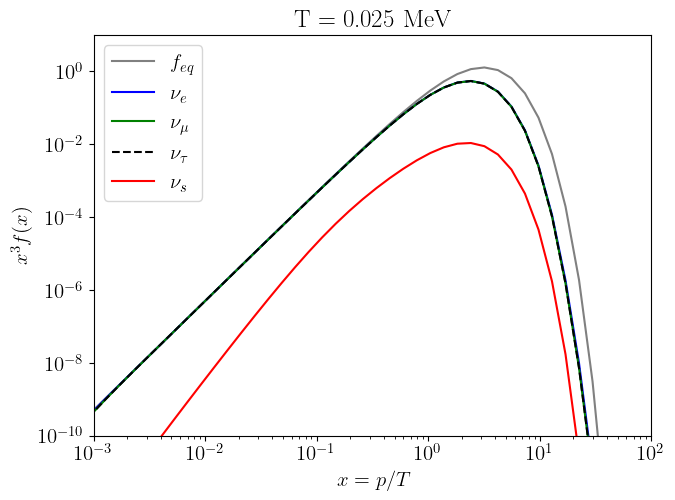

Saved file: f_Trh_5MeV.pdf


In [62]:
plot_momentum_spectra_x(res5, flavors=('e','mu','tau','s'), filename="f_Trh_5MeV.pdf")

In [63]:
resTrh_5_ms_1ep1 = run_ln_comoving_full(TR_MeV=5, ms_keV=1*1e-1, sin2_2theta=1e-2, ln_a_span=(0,10), print_dlna=1.0)

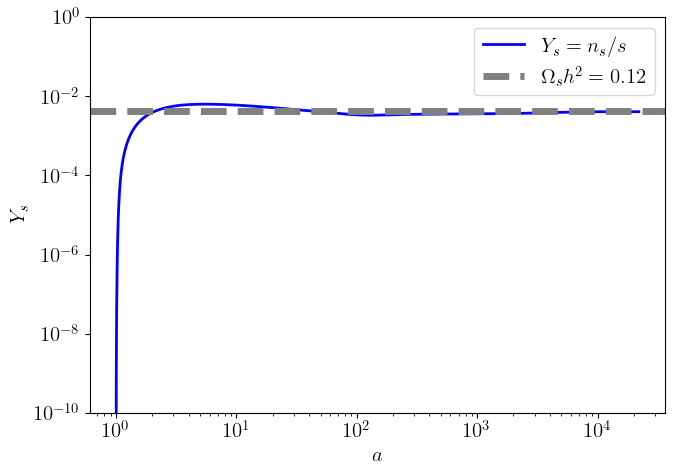

Saved file: Ys_Trh_5MeV_ms_1ep1.pdf


In [64]:
plot_Ys(resTrh_5_ms_1ep1, filename="Ys_Trh_5MeV_ms_1ep1.pdf")

In [4]:
resTrh_5_ms_1ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=1*1e-2, sin2_2theta=1e-1, ln_a_span=(0,10), print_dlna=1.0)

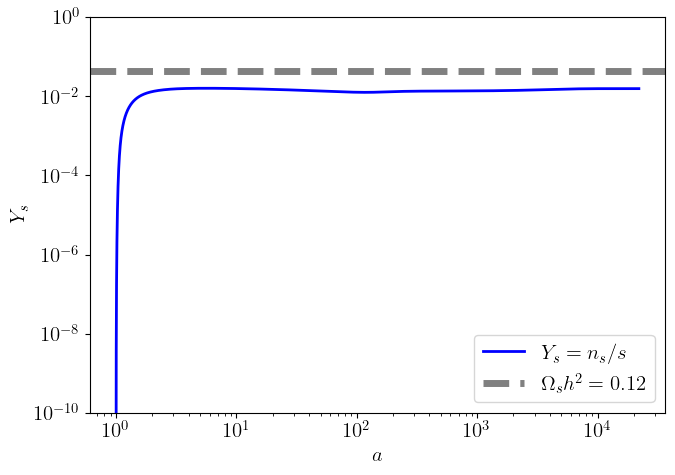

Saved file: Ys_Trh_5_ms_1ep2.pdf


In [7]:
plot_Ys(resTrh_5_ms_1ep2,filename="Ys_Trh_5_ms_1ep2.pdf") 

In [19]:
resTrh_5_ms_1ep2_no_back = run_ln_comoving_full(TR_MeV=5, ms_keV=1*1e-2, sin2_2theta=1e-1, ln_a_span=(0,10), print_dlna=1.0)

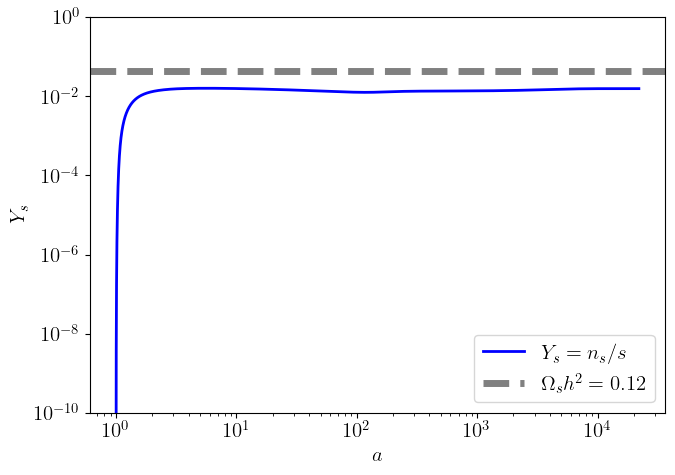

Saved file: Ys_Trh_5_ms_1ep2_no_back.pdf


In [20]:
plot_Ys(resTrh_5_ms_1ep2_no_back,filename="Ys_Trh_5_ms_1ep2_no_back.pdf") 

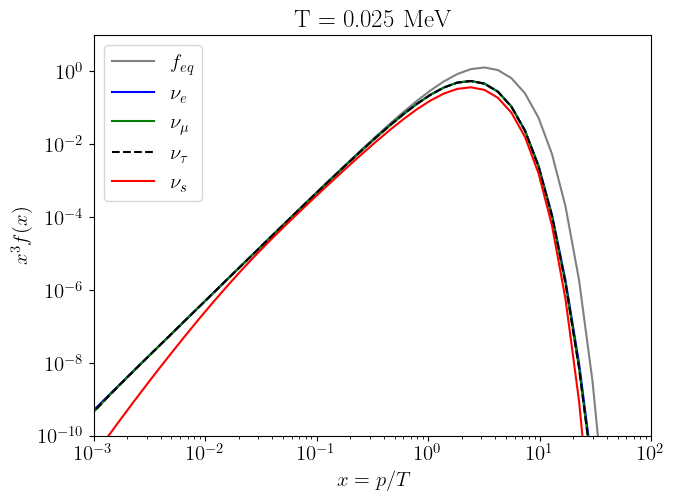

Saved file: f_Trh_5_ms_1ep2_no_back.pdf


In [66]:
plot_momentum_spectra_x(resTrh_5_ms_1ep2_no_back , flavors=('e','mu','tau','s'), filename="f_Trh_5_ms_1ep2_no_back.pdf")

In [133]:
resTrh_5_ms_1p9ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=1.9*1e-2, sin2_2theta=1, ln_a_span=(0,10), print_dlna=1.0)

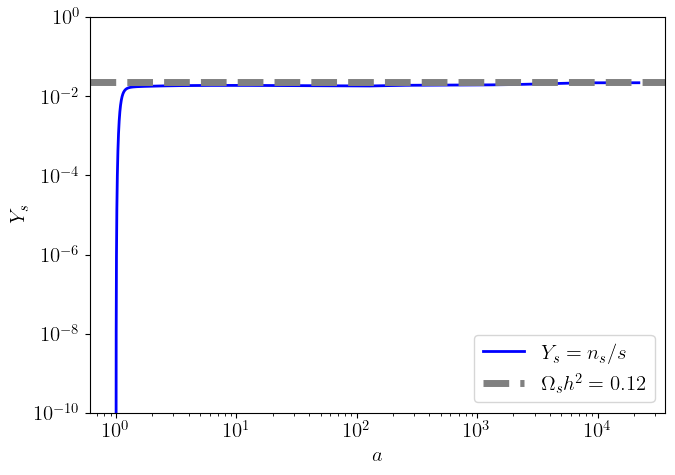

Saved file: Ys_Trh_5_ms_1p9ep2.pdf


In [135]:
plot_Ys(resTrh_5_ms_1p9ep2, filename="Ys_Trh_5_ms_1p9ep2.pdf") 

In [133]:
resTrh_5_ms_2ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=2.0*1e-2, sin2_2theta=0.5, ln_a_span=(0,10), print_dlna=1.0)

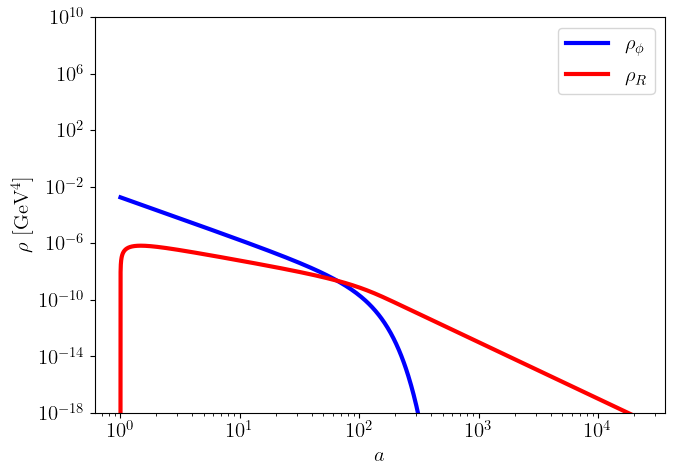

Saved file: rho_Trh_5_ms_2ep2.pdf


In [186]:
plot_energy_densities(resTrh_5_ms_2ep2,filename="rho_Trh_5_ms_2ep2.pdf")

rho_phi = rho_rad at a = 6.531e+01, Temperature T = 5.011 MeV


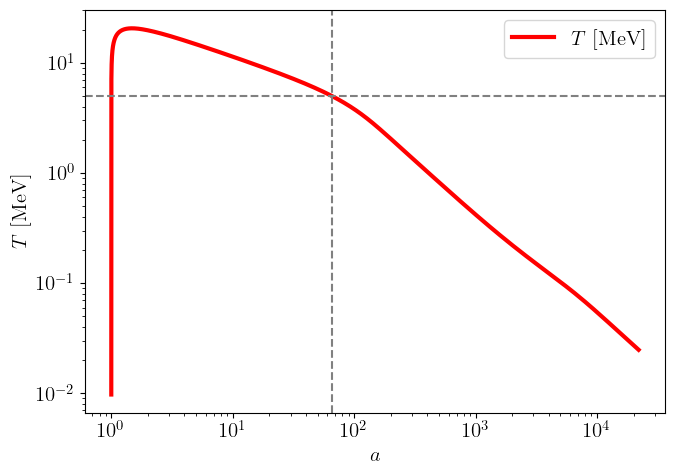

Saved file: T_Trh_5_ms_2ep2.pdf


In [185]:
plot_temperature_evolution(resTrh_5_ms_2ep2 ,filename="T_Trh_5_ms_2ep2.pdf")

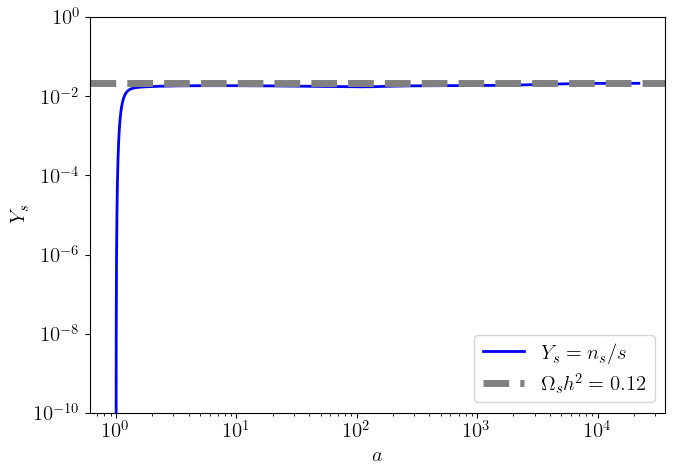

Saved file: Ys_Trh_5_ms_2ep2.pdf


In [187]:
plot_Ys(resTrh_5_ms_2ep2,filename="Ys_Trh_5_ms_2ep2.pdf") 

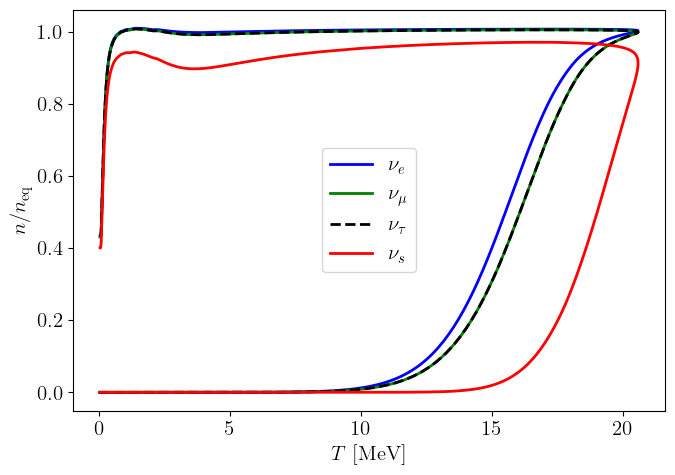

Saved file: n_Trh_5_ms_2ep2.pdf


In [183]:
plot_n_over_n_eq(resTrh_5_ms_2ep2, Tmax_MeV=None,filename="n_Trh_5_ms_2ep2.pdf")

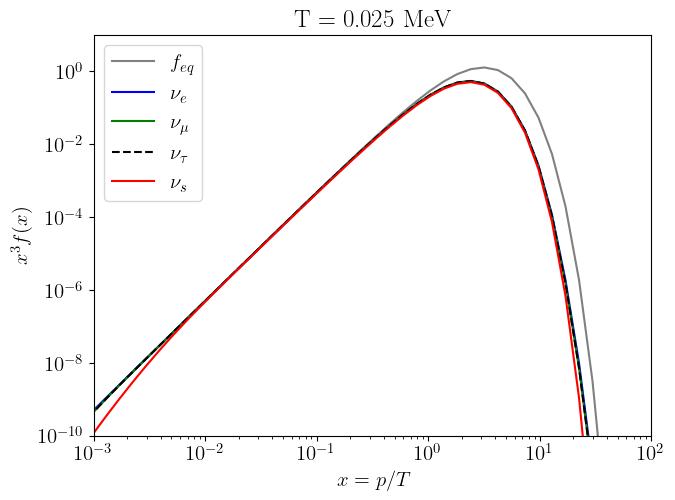

Saved file: f_Trh_5_ms_2ep2.pdf


In [182]:
plot_momentum_spectra_x(resTrh_5_ms_2ep2, flavors=('e','mu','tau','s'), filename="f_Trh_5_ms_2ep2.pdf")

In [138]:
resTrh_5_ms_2p1ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=2.1*1e-2, sin2_2theta=0.3, ln_a_span=(0,10), print_dlna=1.0)

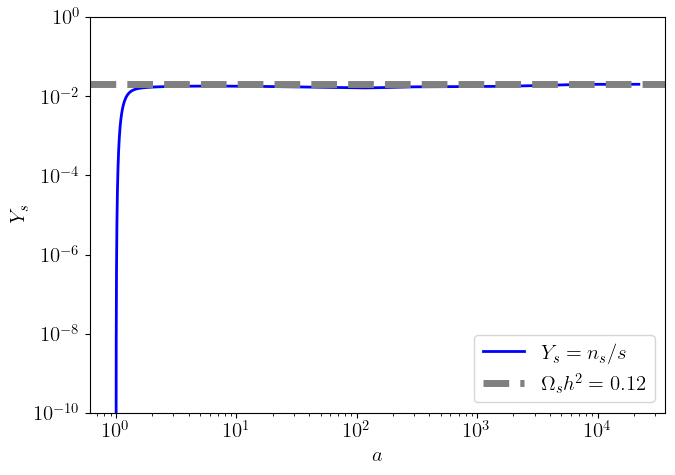

In [139]:
plot_Ys(resTrh_5_ms_2p1ep2) 

In [130]:
resTrh_5_ms_2p2ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=2.2*1e-2, sin2_2theta=0.2, ln_a_span=(0,10), print_dlna=1.0)

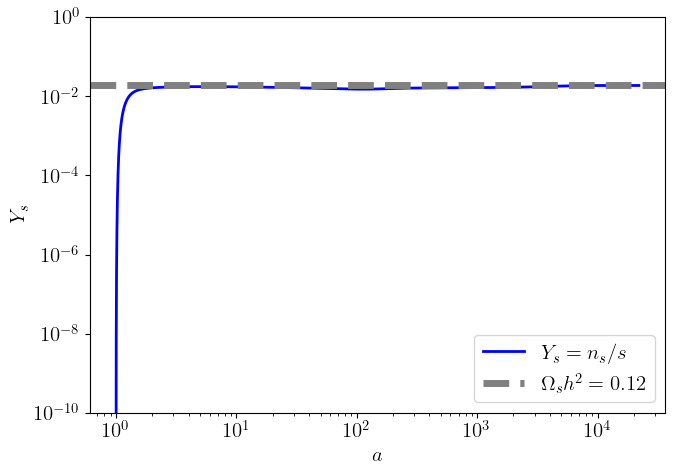

In [131]:
plot_Ys(resTrh_5_ms_2p2ep2) 

In [114]:
resTrh_5_ms_2p7ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=2.7*1e-2, sin2_2theta=0.1, ln_a_span=(0,10), print_dlna=1.0)

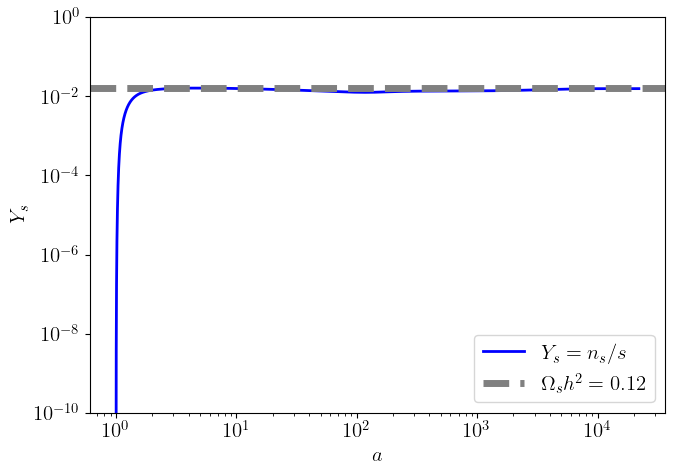

In [115]:
plot_Ys(resTrh_5_ms_2p7ep2) 

In [102]:
resTrh_5_ms_2p5ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=2.5*1e-2, sin2_2theta=0.13, ln_a_span=(0,10), print_dlna=1.0)

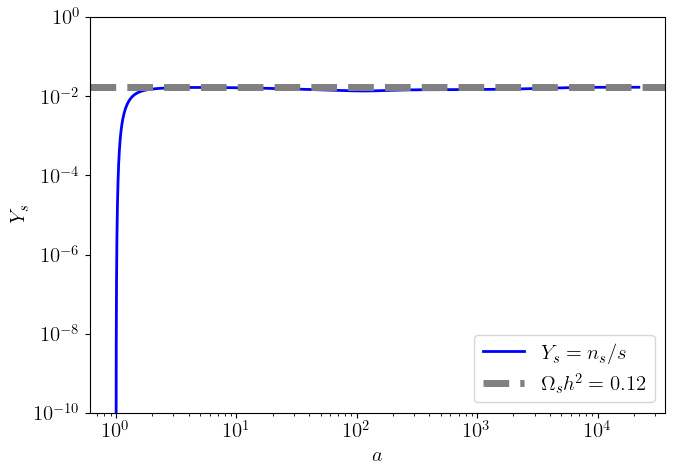

In [103]:
plot_Ys(resTrh_5_ms_2p5ep2) 

In [90]:
resTrh_5_ms_3ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=3*1e-2, sin2_2theta=0.08, ln_a_span=(0,10), print_dlna=1.0)

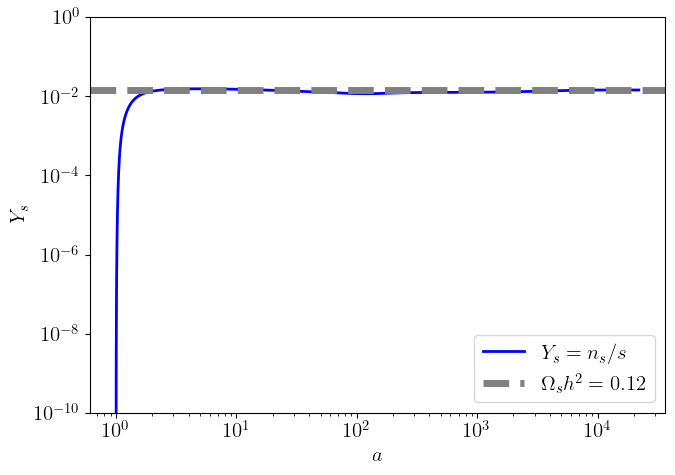

In [91]:
plot_Ys(resTrh_5_ms_3ep2) 

In [75]:
resTrh_5_ms_4ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=4*1e-2, sin2_2theta=0.04, ln_a_span=(0,10), print_dlna=1.0)

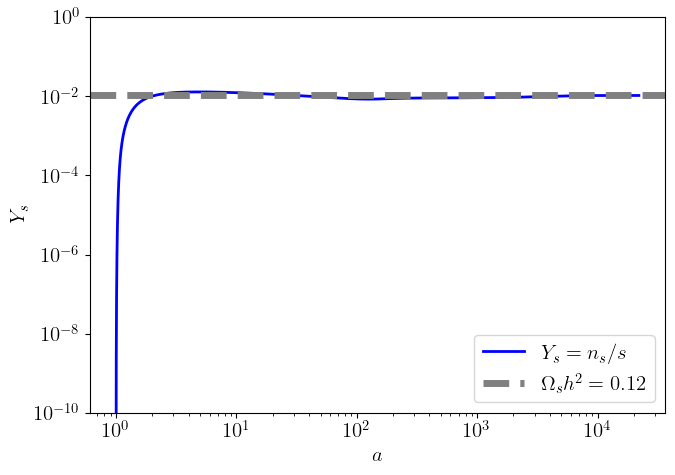

In [76]:
plot_Ys(resTrh_5_ms_4ep2) 

In [95]:
resTrh_5_ms_5ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=5*1e-2, sin2_2theta=0.03, ln_a_span=(0,10), print_dlna=1.0)

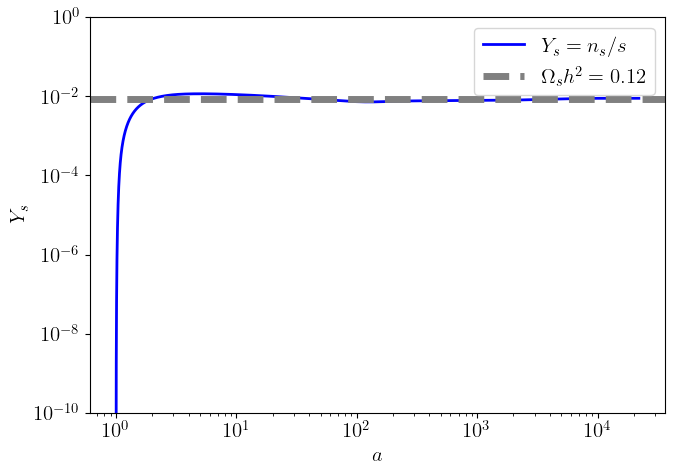

In [96]:
plot_Ys(resTrh_5_ms_5ep2) 

In [85]:
resTrh_5_ms_6ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=6*1e-2, sin2_2theta=0.02, ln_a_span=(0,10), print_dlna=1.0)

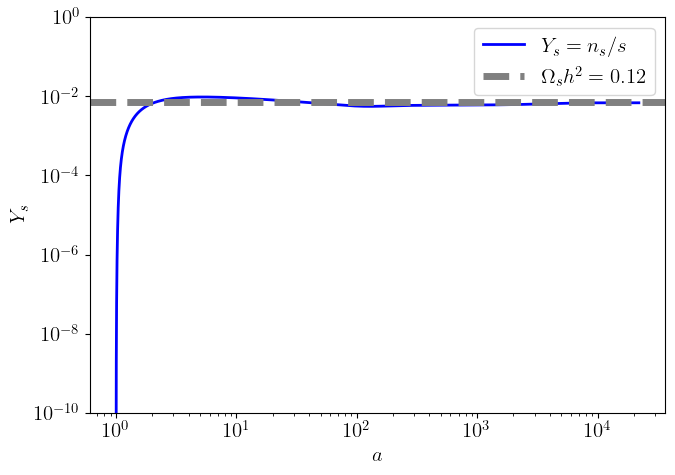

In [86]:
plot_Ys(resTrh_5_ms_6ep2) 

In [ ]:
# 1e-2

In [18]:
resTrh_5_ms_1ep2 = run_ln_comoving_full(TR_MeV=5, ms_keV=1*1e-2, sin2_2theta=1e-1, ln_a_span=(0,10), print_dlna=1.0)

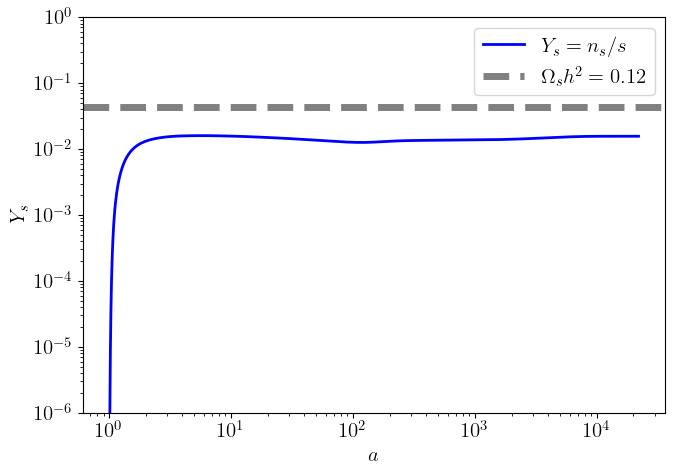

In [19]:
plot_Ys(resTrh_5_ms_1ep2) # if I drop fs in (fa - fs)

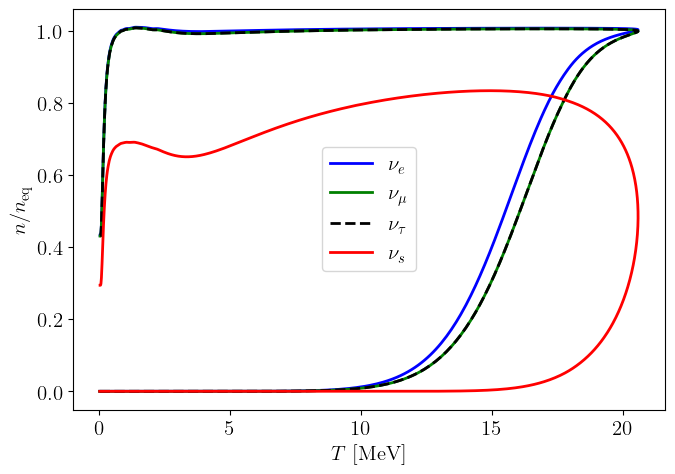

In [22]:
plot_n_over_n_eq(resTrh_5_ms_1ep2, Tmax_MeV=None) # 

rho_phi = rho_rad at a = 6.531e+01, Temperature T = 5.011 MeV


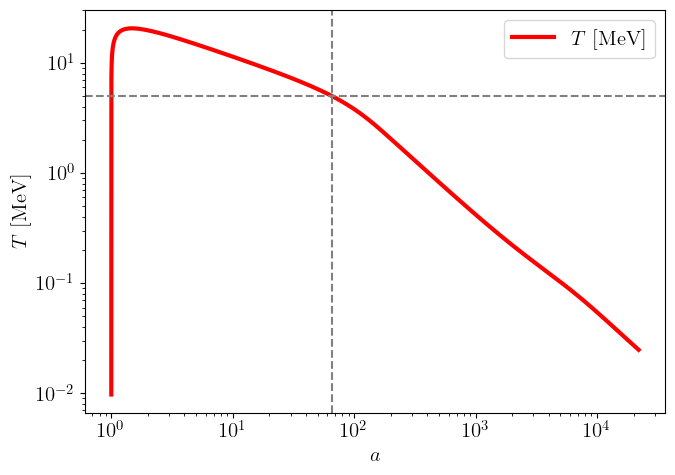

In [24]:
plot_temperature_evolution(resTrh_5_ms_1ep2,filename="T_Trh_200MeV.pdf")

In [39]:
resTrh_5_ms_1ep2_2 = run_ln_comoving_full(TR_MeV=5, Hubble_end = 1e-12, ms_keV=1*1e-2, sin2_2theta=1, ln_a_span=(0,20), print_dlna=1.0)

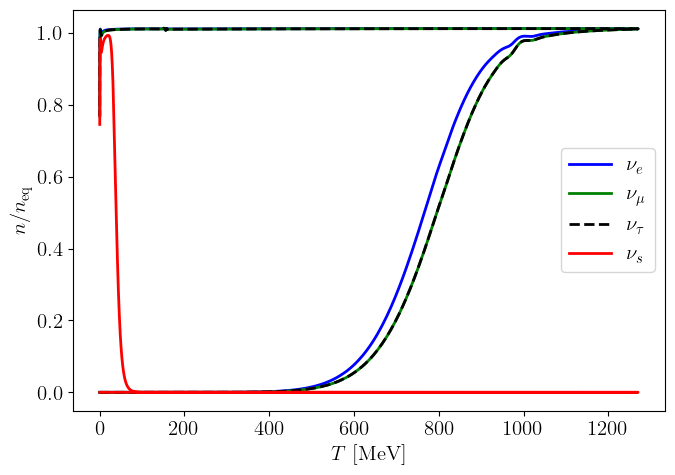

In [40]:
plot_n_over_n_eq(resTrh_5_ms_1ep2_2, Tmax_MeV=None)

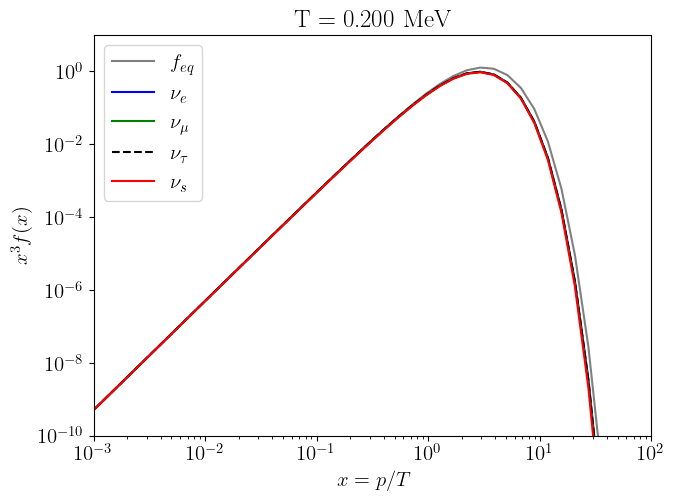

In [41]:
plot_momentum_spectra_x(resTrh_5_ms_1ep2_2, flavors=('e','mu','tau','s'))

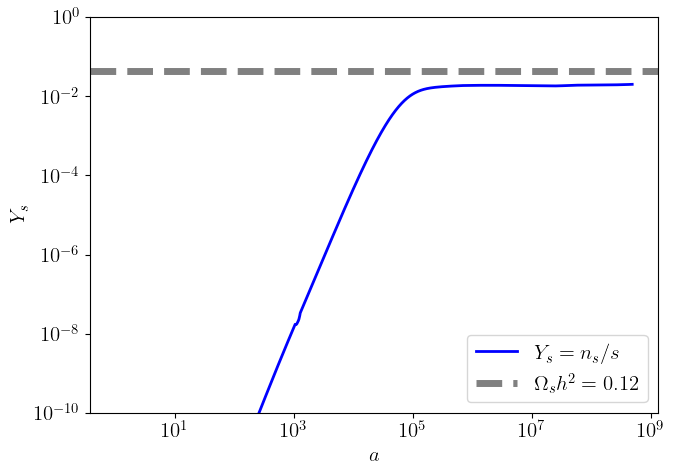

In [42]:
plot_Ys(resTrh_5_ms_1ep2_2) 

In [37]:
resTrh_5_ms_1ep2_3 = run_ln_comoving_full(TR_MeV=5, ms_keV=1*1e-2, sin2_2theta=1, ln_a_span=(0,10), print_dlna=1.0)

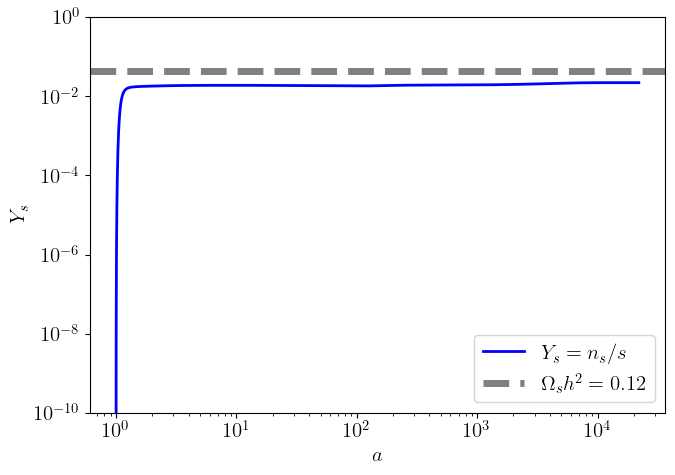

In [38]:
plot_Ys(resTrh_5_ms_1ep2_3) 

In [ ]:
# Lighter  ---> assuming a zero abundance is wrong

In [35]:
resTrh_5_ms_1ep3 = run_ln_comoving_full(TR_MeV=5, ms_keV=1*1e-3, sin2_2theta=1, ln_a_span=(0,10), print_dlna=1.0)

rho_phi = rho_rad at a = 6.531e+01, Temperature T = 5.011 MeV


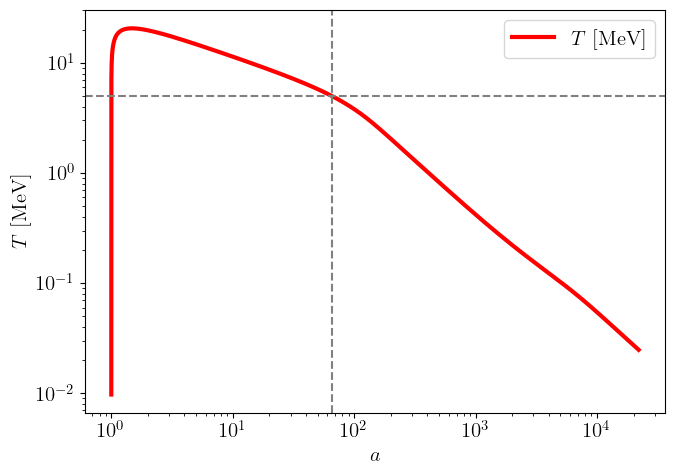

In [36]:
plot_temperature_evolution(resTrh_5_ms_1ep3)

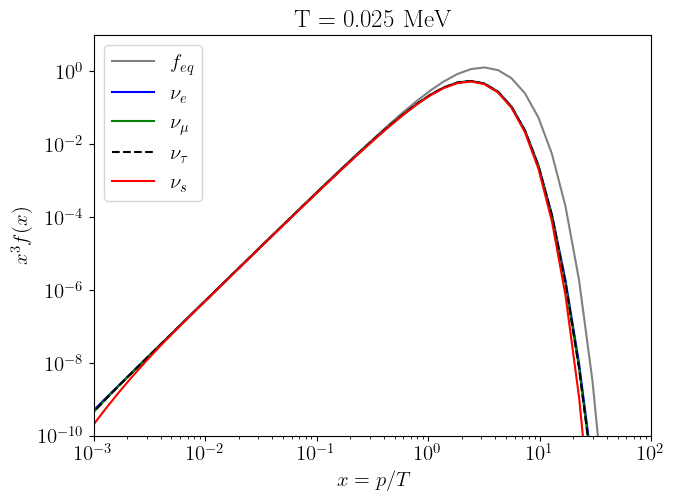

In [37]:
plot_momentum_spectra_x(resTrh_5_ms_1ep3, flavors=('e','mu','tau','s'), filename="f_Trh_5MeV.pdf")

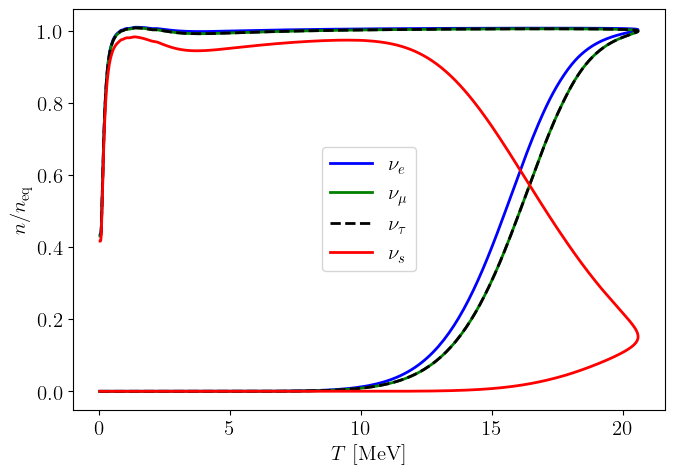

In [38]:
plot_n_over_n_eq(resTrh_5_ms_1ep3, Tmax_MeV=None)

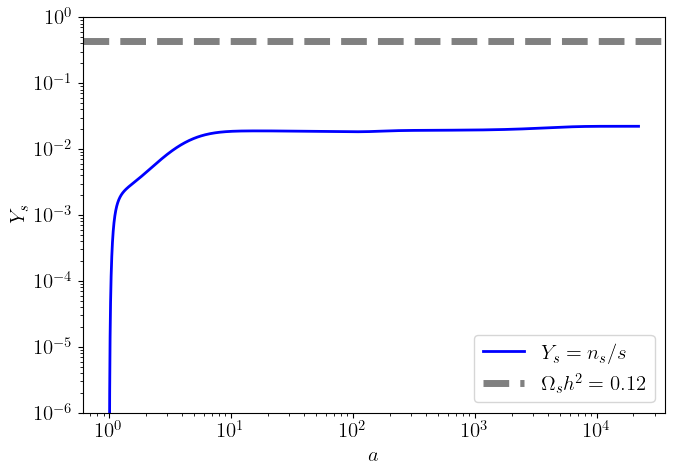

In [39]:
plot_Ys(resTrh_5_ms_1ep3)

In [40]:
resTrh_5_ms_1ep3_2 = run_ln_comoving_full(TR_MeV=5, Hubble_end = 1e-15, ms_keV=1*1e-3, sin2_2theta=1, ln_a_span=(0,20), print_dlna=1.0)

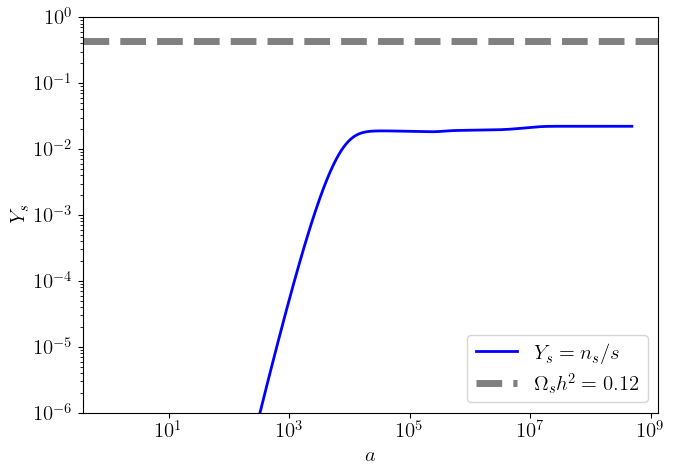

In [46]:
plot_Ys(resTrh_5_ms_1ep3_2)

In [ ]:
# why no entropy dilution???? why frozen????

rho_phi = rho_rad at a = 1.406e+05, Temperature T = 5.012 MeV


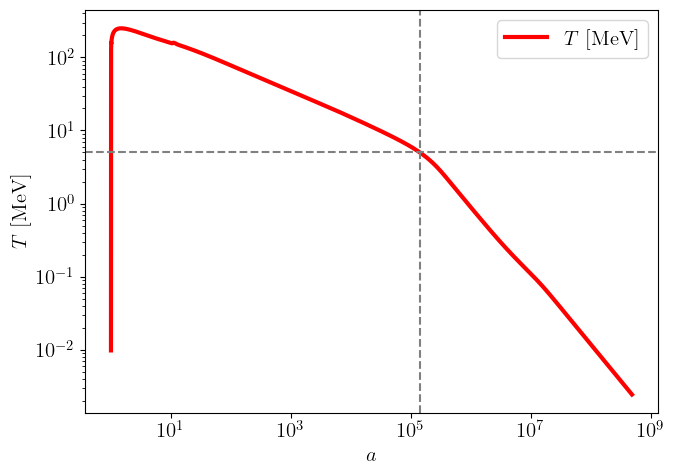

In [49]:
plot_temperature_evolution(resTrh_5_ms_1ep3_2)

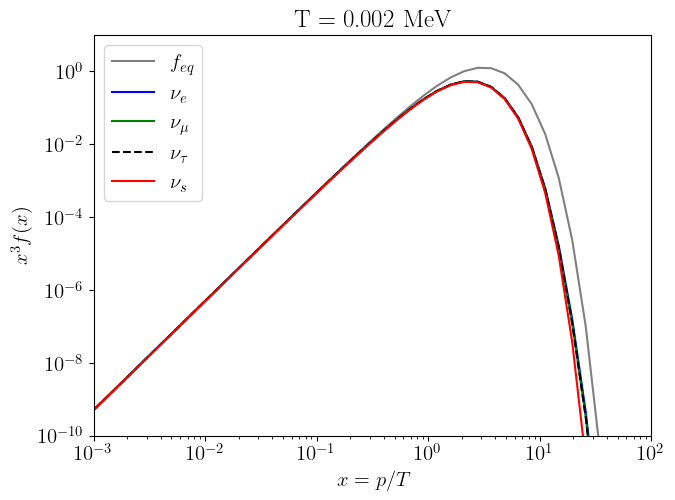

In [48]:
plot_momentum_spectra_x(resTrh_5_ms_1ep3_2, flavors=('e','mu','tau','s'), filename="f_Trh_5MeV.pdf")

In [ ]:
# why freeze-in so quick???

In [ ]:
# resTrh_5_ms_1ep3_2 = run_ln_comoving_full(TR_MeV=5, ms_keV=1*1e-3, sin2_2theta=1, ln_a_span=(0,10), print_dlna=1.0)

In [ ]:
# Heavier

In [128]:
sin2_theta_fun(1e1, 5)

0.0001

In [11]:
resTrh_5_ms_1e1= run_ln_comoving_full(TR_MeV=5, ms_keV=1*1e1, sin2_2theta=1e-4, ln_a_span=(0,10), print_dlna=1.0)

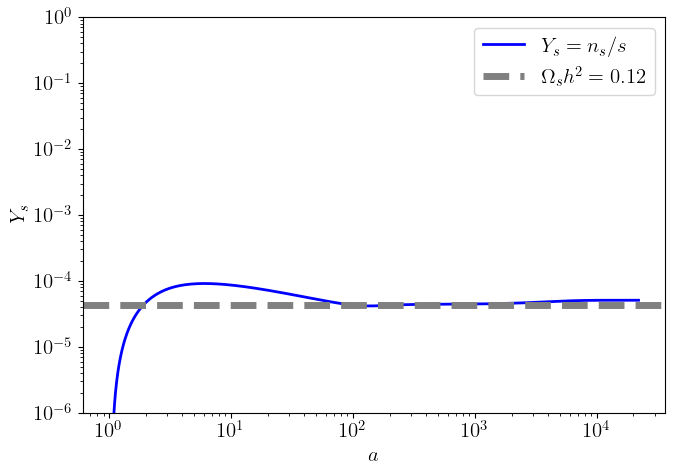

In [12]:
plot_Ys(resTrh_5_ms_1e1)

In [13]:
# why not sensitive to the production during reheating, but also controlled by Trh??? 
# The early production is diluted?

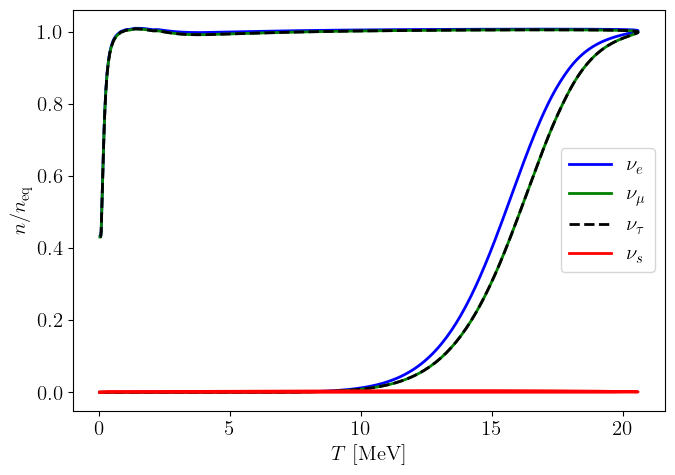

In [14]:
plot_n_over_n_eq(resTrh_5_ms_1e1, Tmax_MeV=None)

In [15]:
# when the transition scale for TRH???

In [27]:
res100= run_ln_comoving_full(TR_MeV=100.0, Hubble_end = 1e-15, ms_keV=1.0, sin2_2theta=5*1e-7, ln_a_span=(0,18), print_dlna=1.0)

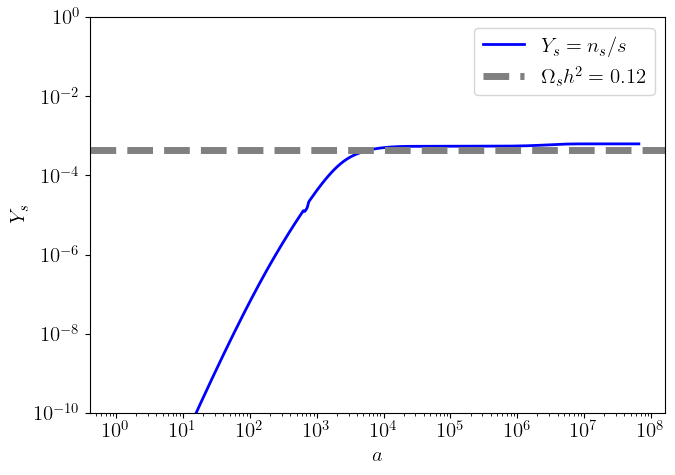

In [28]:
plot_Ys(res100)

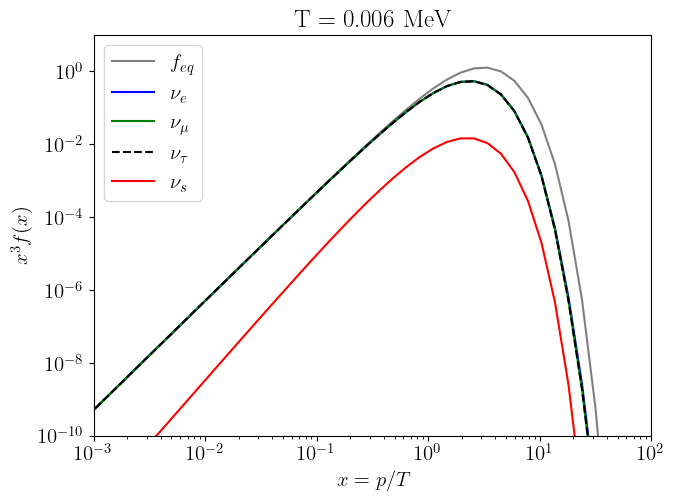

In [29]:
plot_momentum_spectra_x(res100, flavors=('e','mu','tau','s'), filename="f_Trh_5MeV.pdf")

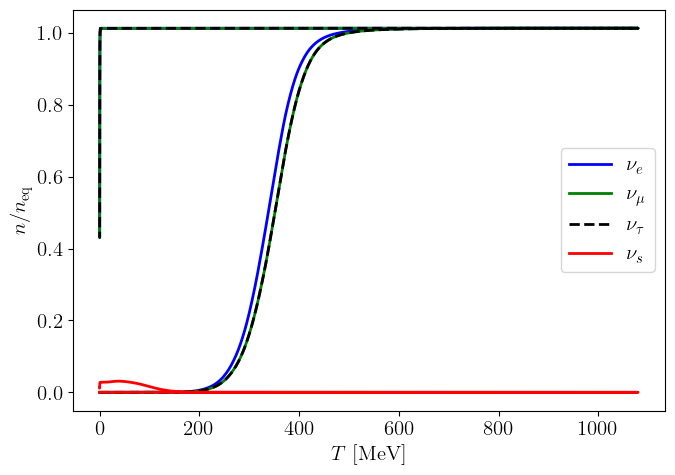

In [30]:
plot_n_over_n_eq(res100)

rho_phi = rho_rad at a = 2.198e+03, Temperature T = 100.218 MeV


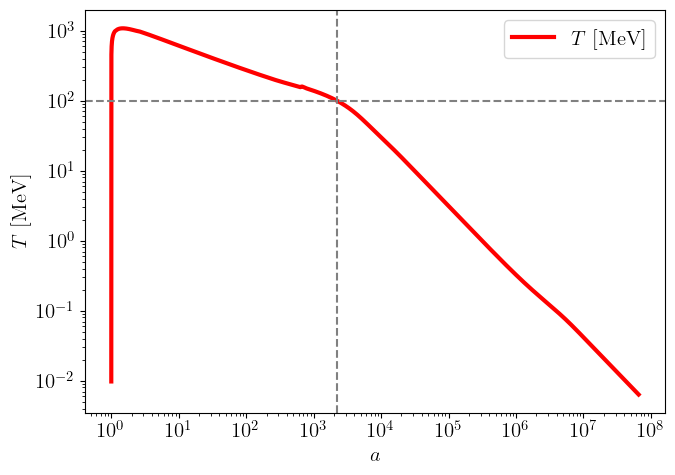

In [31]:
plot_temperature_evolution(res100)

In [ ]:
# 1e 3 keV

In [5]:
resTrh_5_ms_1e3= run_ln_comoving_full(TR_MeV=5, ms_keV=1*1e3, sin2_2theta=1e-6, ln_a_span=(0,10), print_dlna=1.0)

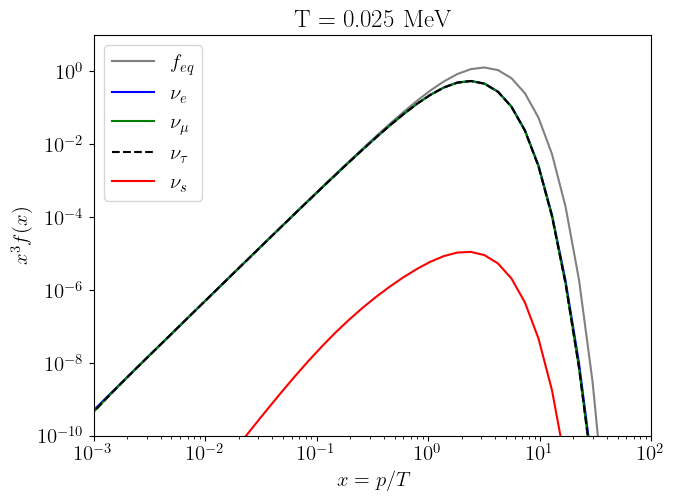

In [7]:
plot_momentum_spectra_x(resTrh_5_ms_1e3, flavors=('e','mu','tau','s'), filename="f_Trh_5MeV.pdf")

rho_phi = rho_rad at a = 6.531e+01, Temperature T = 5.011 MeV


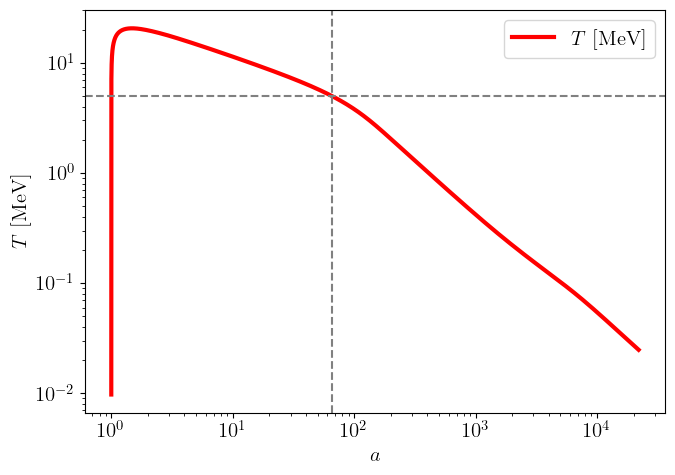

In [9]:
plot_temperature_evolution(resTrh_5_ms_1e3)

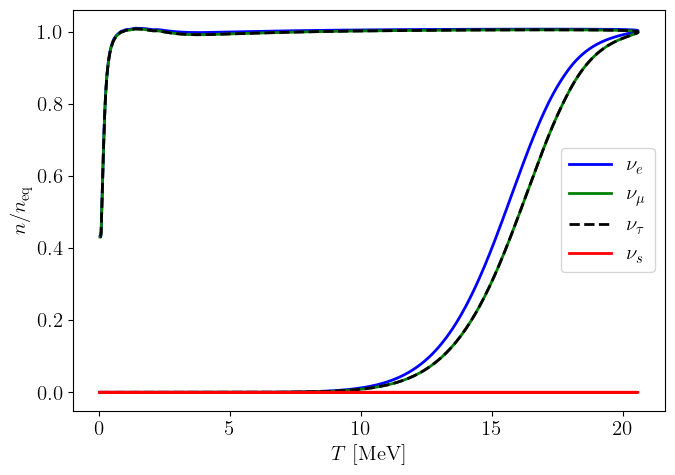

In [8]:
plot_n_over_n_eq(resTrh_5_ms_1e3)

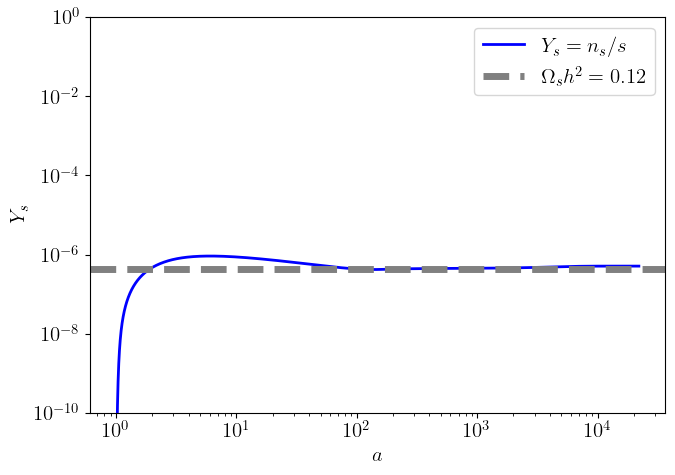

In [16]:
plot_Ys(resTrh_5_ms_1e3)

# Numerical Scan

In [ ]:
# def sin2_theta_fun(ms, Trh):
#     return 1e-3 /ms * (Trh/5)**(-3) 

Starting *narrow* 2D scan...


ms-grid:   0%|                                                      | 0/3 [00:00<?, ?it/s]

Scanning narrow mixing range around ms=1.000e-03 keV


ms-grid:  33%|███████████████                              | 1/3 [04:04<08:09, 244.91s/it]

Scanning narrow mixing range around ms=1.000e-02 keV


ms-grid:  67%|██████████████████████████████               | 2/3 [08:46<04:26, 266.77s/it]

Scanning narrow mixing range around ms=1.000e-01 keV


ms-grid: 100%|█████████████████████████████████████████████| 3/3 [13:12<00:00, 264.11s/it]


Scan finished.
Total time: 792.3 sec


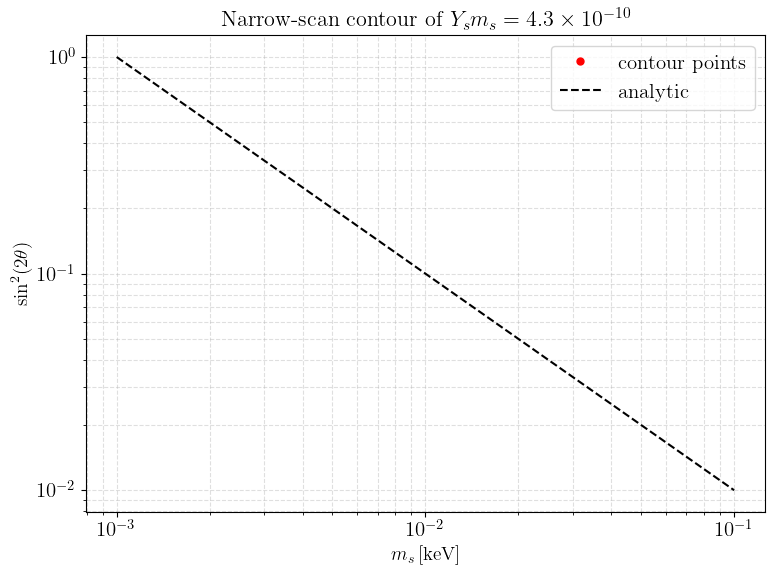

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# -------- ANSI Colors ----------
GREEN  = "\033[92m"
CYAN   = "\033[96m"
YELLOW = "\033[93m"
RESET  = "\033[0m"

# -------------------------------
# USER PARAMETERS
# -------------------------------
TR = 5   # MeV
target = 4.3e-10 / (1e-6)

# ms grid (keV)
ms_values = np.logspace(-3, -1, 3)

# analytic center value
def sin2_theta_fun(ms, Trh): 
    return 1e-3 / ms * (Trh / 5.0)**(-3)

# narrow scan range: 0.9x → 1.1x
def narrow_s2_range(ms):
    center = sin2_theta_fun(ms, TR)
    s2_min = center * 0.1
    s2_max = min(1, center * 10)  # cap at 1
    return np.logspace(np.log10(s2_min), np.log10(s2_max), 10)


# -------------------------------
# Compute Y_s
# -------------------------------
def compute_Ys(TR, ms, sin2_2th):
    result = run_ln_comoving_full(
        TR_MeV       = TR,
        ms_keV       = ms,
        sin2_2theta  = sin2_2th,
        ln_a_span    = (0, 10),
        print_dlna   = 1.0
    )
    return result["Y_s"][-1]


# -------------------------------
# Perform ultra-fast 2D scan
# -------------------------------
print(f"{CYAN}Starting *narrow* 2D scan...{RESET}")
start_time = time.time()

# dynamic storage
MS_list = []
S2_list = []
Y_list  = []

for ms in tqdm(ms_values, desc="ms-grid", ncols=90):

    print(f"{YELLOW}Scanning narrow mixing range around ms={ms:.3e} keV{RESET}")

    s2_range = narrow_s2_range(ms)

    for s2 in s2_range:
        Y_s   = compute_Ys(TR, ms, s2)
        Y_val = Y_s * ms

        MS_list.append(ms)
        S2_list.append(s2)
        Y_list.append(Y_val)


end_time = time.time()
print(f"{GREEN}Scan finished.{RESET}")
print(f"{CYAN}Total time: {end_time - start_time:.1f} sec{RESET}")

# convert to arrays
MS_arr = np.array(MS_list)
S2_arr = np.array(S2_list)
Y_arr  = np.array(Y_list)




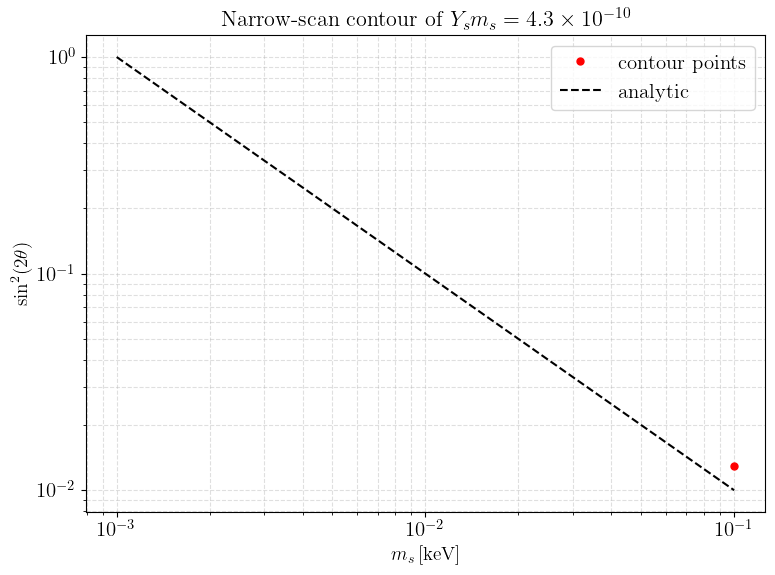

In [19]:
# -------------------------------
# Plot contour (scatter mask method)
# -------------------------------
mask = np.abs(Y_arr - target)/target < 0.2   # within 5%

plt.figure(figsize=(8,6))

plt.loglog(MS_arr[mask], S2_arr[mask], 'ro', label="contour points", markersize=5)

# also plot analytic prediction
plt.loglog(ms_values, sin2_theta_fun(ms_values, TR), 'k--', label="analytic")

plt.xlabel(r"$m_s\,[\rm keV]$", fontsize=14)
plt.ylabel(r"$\sin^2(2\theta)$", fontsize=14)
plt.title(r"Narrow-scan contour of $Y_s m_s = 4.3\times10^{-10}$", fontsize=16)
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
def sin2_theta_fun(ms, Trh):
    return 1e-3 /ms * (Trh/5)**(-3) 

def Xraybound(ms):
    return 1.15*1e-4 * (ms)**(-5)

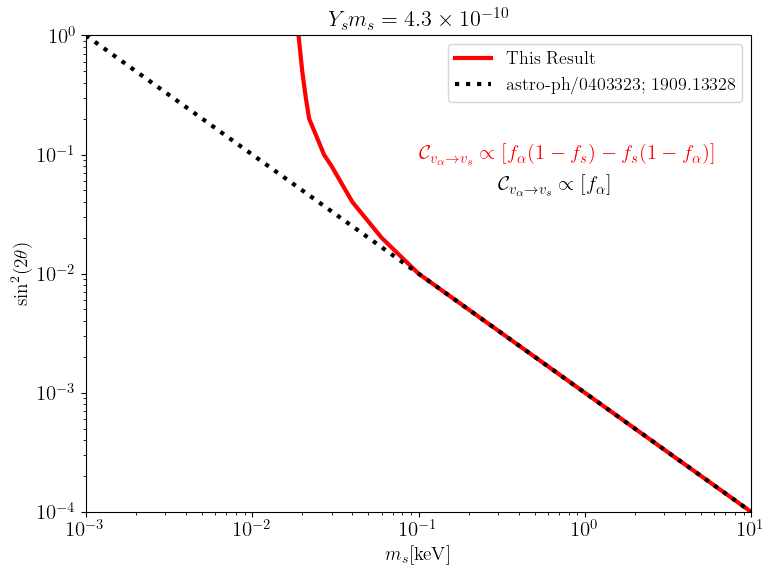

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt

TR = 5
ms_values = np.logspace(-3, 1, 7)

# Red points
ms_red = np.array([1.9e-2, 2.0e-2, 2.1e-2, 2.2e-2, 2.5e-2, 2.7e-2, 3e-2, 4e-2, 6e-2, 1e-1, 1e0, 1e1])
s2_red = np.array([1.0, 0.50, 0.30, 0.20, 0.13, 0.10, 0.08, 0.04, 0.02, 1e-2, 1e-3, 1e-4])

plt.figure(figsize=(8,6))

# Connect red dots with a line
plt.loglog(ms_red, s2_red, 'r-', markersize=8,  linewidth=3,label="This Result")  # 'ro-' means red circles connected

# Analytic prediction
plt.loglog(ms_values, sin2_theta_fun(ms_values, TR), 'k:', linewidth=3, label="astro-ph/0403323; 1909.13328")

# plt.loglog(ms_values, Xraybound(ms_values), 'k:', linewidth=3, label="1909.13328 Gelmini+")
fillx=np.logspace(-3, log10(1.9*1e-2))
# plt.fill_between(fillx, 1e-4, 1e0,color='r',alpha=0.1)
# plt.text(3*1e-3, 1e-2, r'$\Omega_s h^2<0.12$', rotation=0, color = "red")

plt.text(1*1e-1, 0.9*1e-1, r'$\mathcal{C}_{v_\alpha \to v_s} \propto [f_{\alpha}(1-f_s) - f_s(1-f_\alpha)]$', rotation=0, color = "red")

plt.text(3*1e-1, 0.5*1e-1, r'$\mathcal{C}_{v_\alpha \to v_s} \propto [f_{\alpha}]$', rotation=0, color = "black")

plt.xlabel(r'$m_s [\text{keV}]$', fontsize=14)
plt.ylabel(r'$\sin^2(2\theta)$', fontsize=14)
plt.title(r'$Y_s m_s = 4.3\times10^{-10}$', fontsize=16)
plt.legend()
plt.xlim(1e-3,1e1)
plt.ylim(1e-4,1e0)
plt.legend(loc=0, prop={'size': 13} )

plt.savefig("./Compare.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


# With inflaton Decay $ \phi \to \nu_s \nu_s$
* $Y_s = BR \times \frac{T_R}{m_\phi}$

In [206]:
Xray =pd.read_csv(r"/home/yongxu/Documents/research/Research_Code/py_projects/Sterile_Neutrino_Reheating/Xray.csv", 
                  names=['ms','sin2'])
ms_Xray=   Xray.iloc[:,0] # ms
sin2_Xray = Xray.iloc[:,1] # mixing


eROSITA =pd.read_csv(r"/home/yongxu/Documents/research/Research_Code/py_projects/Sterile_Neutrino_Reheating/eROSITA.csv", 
                  names=['ms','sin2'])
ms_eROSITA=   eROSITA.iloc[:,0] # ms
sin2_eROSITA = eROSITA.iloc[:,1] # mixing


eXTP =pd.read_csv(r"/home/yongxu/Documents/research/Research_Code/py_projects/Sterile_Neutrino_Reheating/eXTP.csv", 
                  names=['ms','sin2'])
ms_eXTP=   eXTP.iloc[:,0] # ms
sin2_eXTP= eXTP.iloc[:,1] # mixing


In [243]:
def Ys_Inflaton(Trh, mphi, Br):
    res = 3/2 * Br * Trh/mphi
    return res
10

# Eq.(6.9) astro-ph/0101524v3
def DW_Sin2_2theta(ms):
    return (0.12/0.3) * (100/ms)**2 * 1e-10

In [ ]:
res_test= run_ln_comoving_full(TR_MeV=500.0, 
                               Hubble_end=1e-15, ms_keV=5, sin2_2theta=0.8*1e-9, ln_a_span=(0,15), print_dlna=1.0, mphi=1, BR=1e-4)

In [ ]:
plot_Ys(res_test, filename="Ys_Trh_5MeV_test.pdf")

In [ ]:
res_test["Y_s"][-1] * 5*1e-6

In [ ]:
plot_temperature_evolution(res_test, filename="T_Trh_5MeV_test.pdf")

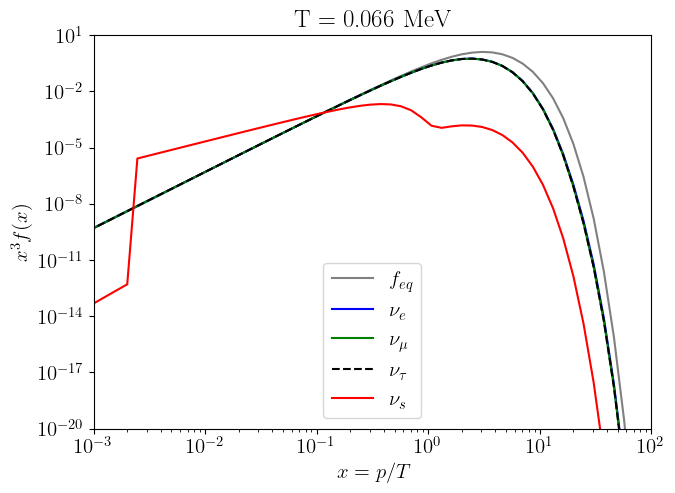

Saved file: f_Trh_5MeV_test.pdf


In [614]:
plot_momentum_spectra_x(res_test, flavors=('e','mu','tau','s'), filename="f_Trh_5MeV_test.pdf")

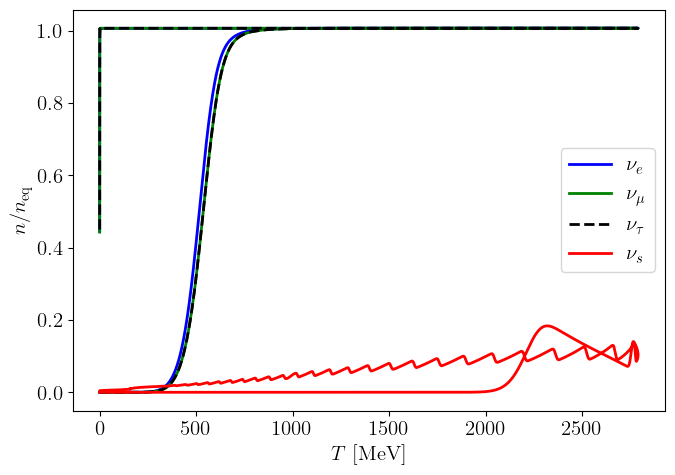

Saved file: n_Trh_5MeV_test.pdf


In [615]:
plot_n_over_n_eq(res_test, Tmax_MeV=None,filename="n_Trh_5MeV_test.pdf")

In [593]:
# HOW TO PRESENT THE RESULTS???

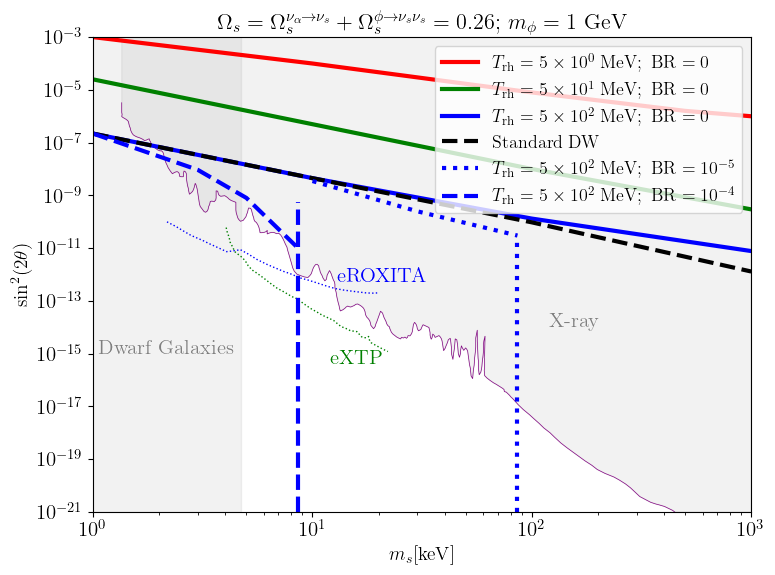

In [617]:
ms_values = np.logspace(-3, 3)
######################################################
# BR =0
#TR=5
ms_TR5 = np.array([1.9e-2, 2.0e-2, 2.1e-2, 2.2e-2, 2.5e-2, 2.7e-2, 3e-2, 4e-2, 6e-2, 1e-1, 1e0, 1e1, 5e1, 1e2, 500, 1000])
s2_TR5 = np.array([1.0, 0.50, 0.30, 0.20, 0.13, 0.10, 0.08, 0.04, 0.02, 1e-2, 1e-3, 1e-4, 1.7*1e-5, 8*1e-6, 1.6*1e-6, 1e-6])

####TR = 200, 1e2, 5*1e-10;

#TR=50
ms_TR50 = np.array([1e0, 1e1, 1e2, 1e3])
s2_TR50 = np.array( [2.5*1e-5, 5*1e-7, 1*1e-8, 2.95*1e-10])


#TR=500
ms_TR500 = np.array([1e0, 1e1, 1e2, 1e3])
s2_TR500 = np.array( [2.2*1e-7, 4.5*1e-9, 1.32*1e-10, 7.75*1e-12])

#TR=800
ms_TR800 = np.array([1e0, 1e1, 1e2, 1e3])
s2_TR800 = np.array( [2.2*1e-7, 4.5*1e-9, 1*1e-10, 2.95*1e-12])

#TR=5000
ms_TR5000 = np.array([1e0, 1e1, 1e2, 1e3])
s2_TR5000 = np.array( [2.2*1e-7, 4.5*1e-9, 0.95*1e-10, 1.3*1e-12])

######################################################
#TR=500; BR=1e-5; mphi=1GeV
ms_TR500_BR1ep5 = np.array([1e1, 3e1, 86])
s2_TR500_BR1ep5 = np.array( [3.5*1e-9, 2.5*1e-10, 3*1e-11])



######################################################
#TR=500; BR=1e-4; mphi=1GeV
ms_TR500_BR1ep4 = np.array([1, 3, 5, 8.6])
s2_TR500_BR1ep4 = np.array( [2.2*1e-7, 9.3*1e-9, 8*1e-10, 1*1e-11])
######################################################

plt.figure(figsize=(8,6))
plt.plot(ms_Xray, sin2_Xray,'purple', linewidth=0.5)
plt.plot(ms_eROSITA, sin2_eROSITA, "b:", linewidth=1)
plt.plot(ms_eXTP, sin2_eXTP, "g:", linewidth=1)

######################################################
plt.loglog(ms_TR5, s2_TR5, 'r-', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\times 10^{0}~\text{MeV};~\text{BR}=0$')  # 'ro-' means red circles connected
plt.loglog(ms_TR50, s2_TR50, 'g-', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\times 10^{1}~\text{MeV};~\text{BR}=0$')  # 'ro-' means red circles connected
plt.loglog(ms_TR500, s2_TR500, 'b-', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\times 10^{2}~\text{MeV};~\text{BR}=0$')  # 'ro-' means red circles connected

# plt.loglog(ms_BR, s2_BR, 'ko-', markersize=8,  linewidth=3,label="Num BR = 5.8*1e-6")  # 'ro-' means red circles connected
# plt.loglog(ms_TR800, s2_TR800, 'go-', markersize=8,  linewidth=3,label=r'$T_\text{rh} =800~\text{MeV};~\text{BR}=0$')  # 'ro-' means red circles connected
# plt.loglog(ms_TR5000, s2_TR5000, 'k--', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\times 10^{3}~\text{MeV};~\text{BR}=0$')  # 'ro-' means red circles connected
plt.loglog(ms_TR5000, s2_TR5000, 'k--', markersize=8,  linewidth=3,label=r'$\text{Standard DW}$')  # 'ro-' means red circles connected

# Analytic prediction
# plt.loglog(ms_values, sin2_theta_fun(ms_values, TR), 'k:', linewidth=3, label="Ana")
# plt.loglog(ms_values, DW_Sin2_2theta(ms_values), 'b:', linewidth=3, label="Standard Dodelson Widrow")

#################################################################
plt.loglog(ms_TR500_BR1ep5, s2_TR500_BR1ep5, 'b:', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\times 10^{2}~\text{MeV};~\text{BR}=10^{-5}$')  # 'ro-' means red circles connected

plt.loglog(ms_TR500_BR1ep4, s2_TR500_BR1ep4, 'b--', markersize=8,  linewidth=3,label=r'$T_\text{rh} =5\times 10^{2}~\text{MeV};~\text{BR}=10^{-4}$')  # 'ro-' means red circles connected


######################################################
######################################################
plt.axvline(x=86, ymin=1e-12,ymax=0.57, color='blue', linestyle=':', linewidth=3)
plt.axvline(x=8.6, ymin=1e-12,ymax=0.6, color='blue', linestyle='--', linewidth=3)


fillxLy=np.logspace(-3, log10(4.71))
plt.fill_between(fillxLy, 1e-21, 1e0,color='gray',alpha=0.1)

# First filled region (between curve and large y2)
x1 = ms_Xray
y1_lower = sin2_Xray
y1_upper = np.ones_like(sin2_Xray) * max(sin2_Xray) * 1e10   # constant upper boundary

# Second filled region (rectangle from max(ms_Xray) to 1e3)
x2 = np.logspace(np.log10(max(ms_Xray)), 3)
y2_lower = np.ones_like(x2) * 1e-21
y2_upper = np.ones_like(x2) * 1e0

# Combine into one polygon (go around boundary)
xs = np.concatenate([x1, x2, x2[::-1], x1[::-1]])
ys = np.concatenate([y1_upper, y2_upper, y2_lower[::-1], y1_lower[::-1]])

plt.fill(xs, ys, alpha=0.1, color="gray")
plt.text(1.05*1e0, 1e-15, r'$\text{Dwarf Galaxies}$', rotation=0, color = "gray")

plt.text(1.2*1e2, 1e-14, r'$\text{X-ray}$', rotation=0, color = "gray")
plt.text(1.3*1e1, 0.5*1e-12, r'$\text{eROXITA}$', rotation=0, color = "b")
plt.text(1.2*1e1, 0.4*1e-15, r'$\text{eXTP}$', rotation=0, color = "g")

#################################################################

plt.xlabel(r'$m_s [\text{keV}]$', fontsize=14)
plt.ylabel(r'$\sin^2(2\theta)$', fontsize=14)
# plt.title(r'$Y_s m_s = 4.3\times10^{-10}~\text{GeV}; m_\phi =1~\text{GeV}$', fontsize=16)

plt.title(r'$\Omega_s= \Omega^{\nu_{\alpha} \to \nu_s}_s +\Omega^{\phi \to \nu_s \nu_s}_s =0.26;\,  m_\phi =1~\text{GeV}$', fontsize=16)

plt.legend()
plt.xlim(1e0,1e3)
plt.ylim(1e-21,1e-3)
plt.legend(loc='upper right', prop={'size': 13} )

plt.savefig("./PS.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


In [566]:
# would oscillation affect the decay? or vice versa???? it seems no,  but I can have oscillation only generate 0.1% DM !!!

In [ ]:
# If  a positive signal (1e2, 1e-18) ---> BR and Inflaton mass!!!